In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, LeakyReLU, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
import numpy as np
import random
import pandas as pd
from typing import Tuple, List
import traceback
from evaluate.utils import plot_tsne_extended

# Seeds for reproducibility
seed_value = 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os

os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

In [3]:
def create_cnn(input_dim: int = 25,
               output_dim: int = 1,
               filters: int = 32,
               kernel_size: int = 10,
               repr_dim: int = 50) -> Model:
    """
    Create a CNN model with 1D convolutional layers and a fully connected layer.

    Parameters:
    input_dim (int): The number of timesteps in the input data. Default is 25.
    output_dim (int): The dimension of the output layer. Default is 1 for regression tasks.
    filters (int): The number of filters in each convolutional layer. Default is 9.
    kernel_size (int): The size of the kernel in the convolutional layers. Default is 10.
    repr_dim (int): The number of units in the fully connected layer. Default is 50.

    Returns:
    Model: A Keras model instance.
    """

    # Define the input layer
    input_layer = Input(shape=(input_dim, 1))

    # Add convolutional layers with LeakyReLU activation
    conv1 = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(input_layer)
    conv1 = LeakyReLU()(conv1)
    conv2 = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(conv1)
    conv2 = LeakyReLU()(conv2)

    # Flatten the output for the fully connected layer
    flattened = Flatten()(conv2)

    # Add a fully connected layer with LeakyReLU activation
    dense = Dense(repr_dim)(flattened)
    repr_output = LeakyReLU(name='repr_layer')(dense)

    # Output layer
    output_layer = Dense(output_dim, name='forecast_head')(repr_output)

    # Create the model
    model = Model(inputs=input_layer, outputs=[repr_output, output_layer])

    return model

In [4]:
def create_mlp(input_dim: int = 25, output_dim: int = 1, hiddens=None, repr_dim: int = 9) -> Model:
    """
    Create an MLP model with fully connected dense layers.

    Parameters:
    - input_dim (int): The number of features in the input data.
    - output_dim (int): The dimension of the output layer. Default is 1 for regression tasks.
    - hiddens (list): A list of integers where each integer is the number of units in a hidden layer.
    - repr_dim (int): The number of features in the final representation vector.

    Returns:
    - Model: A Keras model instance.
    """

    # Define the input layer
    if hiddens is None:
        hiddens = [100, 100, 50]
    input_layer = Input(shape=(input_dim,))

    # Create hidden layers with LeakyReLU activation
    x = input_layer
    for units in hiddens:
        x = Dense(units)(x)
        x = LeakyReLU()(x)
        
    # Final representation layer
    repr_output = Dense(repr_dim)(x)
    repr_output = LeakyReLU(name='repr_layer')(repr_output)

    # Output layer
    output_layer = Dense(output_dim, name='forecast_head')(repr_output)

    # Create the model
    model = Model(inputs=input_layer, outputs=[repr_output, output_layer])

    return model

In [5]:
def create_y_shaped_model(cnn_input_dim: int = 25,
                          mlp_input_dim: int = 21,
                          output_dim: int = 1,
                          repr_dim: int = 10,
                          cnn_filters: int = 32,
                          cnn_kernel_size: int = 10,
                          cnn_repr_dim: int = 50,
                          mlp_repr_dim: int = 9,
                          mlp_hiddens=None,
                          final_hiddens=None) -> Model:
    """
    Create a Y-shaped neural network model with a CNN branch and an MLP branch, using Leaky ReLU activations.
    The model outputs both the final predicted value and the final representation vector.

    Parameters:
    - cnn_input_dim (int): The number of timesteps for the CNN branch.
    - mlp_input_dim (int): The number of features for the MLP branch.
    - output_dim (int): The dimension of the output layer.
    - repr_dim (int): The number of features in the final representation vector.
    - cnn_filters (int): The number of filters in the CNN layers.
    - cnn_kernel_size (int): The size of the kernel in the CNN layers.
    - cnn_repr_dim (int): The number of features in the representation vector after the CNN branch.
    - mlp_repr_dim (int): The number of features in the representation vector after the MLP branch.
    - mlp_hiddens (List[int]): List of integers for the MLP hidden layers.
    - final_hiddens (List[int]): List of integers representing the number of units in each hidden layer after concatenation.

    Returns:
    - Model: A Keras model instance.
    """

    # CNN Branch
    if final_hiddens is None:
        final_hiddens = [12]
    if mlp_hiddens is None:
        mlp_hiddens = [18]
    cnn_input = Input(shape=(cnn_input_dim, 1))
    x_cnn = Conv1D(filters=cnn_filters, kernel_size=cnn_kernel_size, padding='same')(cnn_input)
    x_cnn = LeakyReLU()(x_cnn)
    x_cnn = Conv1D(filters=cnn_filters, kernel_size=cnn_kernel_size, padding='same')(x_cnn)
    x_cnn = LeakyReLU()(x_cnn)
    x_cnn = Flatten()(x_cnn)
    x_cnn = Dense(cnn_repr_dim)(x_cnn)
    cnn_repr = LeakyReLU()(x_cnn)

    # MLP Branch
    mlp_input = Input(shape=(mlp_input_dim,))
    x_mlp = mlp_input
    for units in mlp_hiddens:
        x_mlp = Dense(units)(x_mlp)
        x_mlp = LeakyReLU()(x_mlp)
    x_mlp = Dense(mlp_repr_dim)(x_mlp)
    mlp_repr = LeakyReLU()(x_mlp)

    # Concatenate the output of CNN and MLP branches
    concatenated = Concatenate()([cnn_repr, mlp_repr])

    # Additional MLP Layer(s) after concatenation
    x_combined = concatenated
    for units in final_hiddens:
        x_combined = Dense(units)(x_combined)
        x_combined = LeakyReLU()(x_combined)

    # Final representation layer
    final_repr = Dense(repr_dim)(x_combined)
    final_repr = LeakyReLU(name='repr_layer')(final_repr)

    # Final output layer
    forecast_head = Dense(output_dim, activation='linear', name='forecast_head')(final_repr)

    # Create the model with two outputs: final predicted value and final representation vector
    model = Model(inputs=[cnn_input, mlp_input], outputs=[final_repr, forecast_head])

    return model

In [6]:
def build_dataset(directory_path: str, shuffle_data: bool = True, apply_log: bool = True, norm_target: bool = False) -> \
        Tuple[np.ndarray, np.ndarray]:
    """
    Reads SEP event files from the specified directory, processes them to extract
    input and target data, normalizes the values between 0 and 1 for the columns
    of interest, excludes rows where proton intensity is -9999, and optionally shuffles the data.
    
    Parameters:
    - directory_path (str): Path to the directory containing the sep_event_X files.
    - shuffle_data (bool): If True, shuffle the data before returning.
    - apply_log (bool): Whether to apply a logarithmic transformation before normalization.
    - norm_target (bool): Whether to normalize the target data. False by default.
    
    
    Returns:
    - Tuple[np.ndarray, np.ndarray]: A tuple containing the normalized input data (X) and target data (y).
    """
    all_inputs = []
    all_targets = []

    # Define input and target columns
    input_columns = [f'tminus{i}' for i in range(24, 0, -1)] + ['t']  # Columns from tminus24 to t
    target_column = 'Proton Intensity'

    # Loop through each file in the directory
    for file_name in os.listdir(directory_path):
        if file_name.endswith('_ie.csv'):
            file_path = os.path.join(directory_path, file_name)
            data = pd.read_csv(file_path)

            # Exclude rows where proton intensity is -9999
            data = data[data[target_column] != -9999]

            # Apply logarithmic transformation (if specified)
            if apply_log:
                data[input_columns] = np.log(data[input_columns] + 1)  # Adding 1 to avoid log(0)
                data[target_column] = np.log(data[target_column] + 1)  # Adding 1 to avoid log(0)

            # Normalize inputs between 0 and 1
            input_data = data[input_columns]
            input_data_normalized = (input_data - input_data.min()) / (input_data.max() - input_data.min())

            # Normalize targets between 0 and 1
            target_data = data[[target_column]]
            if norm_target:
                target_data_normalized = (target_data - target_data.min()) / (target_data.max() - target_data.min())
            else:
                target_data_normalized = target_data

            # Reshape inputs to be in the format [samples, time steps, features]
            X = input_data_normalized.values.reshape((input_data_normalized.shape[0], 25, 1))

            # Flatten targets to 1D array
            y = target_data_normalized.values.flatten()

            # Append to list
            all_inputs.append(X)
            all_targets.append(y)

    # Combine all input and target data
    X_combined = np.vstack(all_inputs)
    y_combined = np.concatenate(all_targets)

    # Shuffle the data if the flag is True
    if shuffle_data:
        X_combined, y_combined = shuffle(X_combined, y_combined, random_state=seed_value)

    return X_combined, y_combined

In [7]:
def check_nan_in_dataset(dataset: np.ndarray, dataset_name: str) -> None:
    """
    Checks if there are any NaN values in the given dataset and prints the result.

    Parameters:
    - dataset (np.ndarray): The dataset to check for NaN values.
    - dataset_name (str): The name of the dataset (for display purposes).
    """
    if np.isnan(dataset).any():
        print(f"NaN values found in {dataset_name}.")
    else:
        print(f"No NaN values in {dataset_name}.")

In [8]:
def min_max_norm(data: pd.DataFrame or pd.Series) -> pd.DataFrame or pd.Series:
    """
    Apply min-max normalization to a pandas DataFrame or Series. 
    If the min and max values of a column are the same, that column is replaced with zeros.

    Parameters:
    - data (pd.DataFrame or pd.Series): The pandas DataFrame or Series to be normalized.

    Returns:
    - pd.DataFrame or pd.Series: Min-max normalized pandas DataFrame or Series.
    """

    # Function to normalize a single column
    def normalize_column(column: pd.Series) -> pd.Series:
        min_val = column.min()
        max_val = column.max()

        # Handle case where max and min are the same
        if min_val == max_val:
            return pd.Series(np.zeros_like(column), index=column.index)
        else:
            # Apply min-max normalization
            return (column - min_val) / (max_val - min_val)

    # Check if the input is a DataFrame
    if isinstance(data, pd.DataFrame):
        normalized_df = data.apply(normalize_column, axis=0)
        return normalized_df

    # Check if the input is a Series
    elif isinstance(data, pd.Series):
        return normalize_column(data)

    else:
        raise TypeError("Input must be a pandas DataFrame or Series")

In [9]:
def preprocess_cme_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply efficient preprocessing steps to the given dataframe based on the specified scheme table.
    
    Parameters:
    - df (pd.DataFrame): The dataframe to preprocess.
    
    Returns:
    - pd.DataFrame: The preprocessed dataframe.
    """

    # Preallocate a dictionary to store preprocessed data
    preprocessed_data = {}

    # Natural Log Transformations
    preprocessed_data['log_max_e_intensity'] = np.log1p(df['Max Electron Intensity'])
    preprocessed_data['log_half_richardson_value'] = np.log1p(-df['half_richardson_value'])
    preprocessed_data['log_diffusive_shock'] = np.log1p(df['diffusive_shock'])
    preprocessed_data['log_Type2_Viz_Area'] = df['Type2_Viz_Area'].apply(lambda x: np.log(x) if x != 0 else np.log(1))

    # Apply Min-Max normalization on all features, including the log-transformed ones
    for feature, proper_name in {'VlogV': 'VlogV',
                                 'CME_DONKI_speed': 'CME_DONKI_speed',
                                 'Linear_Speed': 'CME_CDAW_LinearSpeed',
                                 '2nd_order_speed_final': '2nd_order_speed_final',
                                 '2nd_order_speed_20R': '2nd_order_speed_20R',
                                 'CMEs_with_speed_over_1000_in_past_9hours': 'CMEs Speed > 1000',
                                 'max_CME_speed_in_past_day': 'Max CME Speed',
                                 'CMEs_in_past_month': 'CMEs Past Month',
                                 'CME_DONKI_longitude': 'CME_DONKI_longitude',
                                 'CME_CDAW_MPA': 'CME_CDAW_MPA',
                                 'daily_sunspots': 'Sunspot Number',
                                 'DONKI_half_width': 'DONKI_half_width',
                                 'CME_DONKI_latitude': 'CME_DONKI_latitude',
                                 'Accelaration': 'Accelaration',
                                 'CPA': 'CPA',
                                 'CMEs_in_past_9hours': 'CMEs Past 9 Hours'}.items():
        preprocessed_data[f"{feature}_norm"] = min_max_norm(df[proper_name])

    # Apply min-max normalization to log-transformed features
    preprocessed_data['log_max_e_intensity_norm'] = min_max_norm(preprocessed_data['log_max_e_intensity'])
    preprocessed_data['log_richardson_value_norm'] = min_max_norm(preprocessed_data['log_half_richardson_value'])
    preprocessed_data['log_diffusive_shock_norm'] = min_max_norm(preprocessed_data['log_diffusive_shock'])
    preprocessed_data['log_Type2_Viz_Area_norm'] = min_max_norm(preprocessed_data['log_Type2_Viz_Area'])

    # No transformation for 'Halo'
    preprocessed_data['Halo'] = df['Halo']

    # drop log_richardson_formula_1.0_c, diffusive shock, log_Type_2_Area because they are not needed anymore
    preprocessed_data.pop('log_max_e_intensity')
    preprocessed_data.pop('log_half_richardson_value')
    preprocessed_data.pop('log_diffusive_shock')
    preprocessed_data.pop('log_Type2_Viz_Area')

    return pd.DataFrame(preprocessed_data)

In [10]:
def build_full_dataset(
        directory_path: str,
        shuffle_data: bool = True,
        apply_log: bool = True,
        norm_target: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    """
    Reads SEP event files from the specified directory, processes them to extract
    input and target data including cme features, normalizes the values between 0 and 1 for the columns
    of interest, excludes rows where proton intensity is -9999, and optionally shuffles the data.
    
    Parameters:
    - directory_path (str): Path to the directory containing the sep_event_X files.
    - shuffle_data (bool): If True, shuffle the data before returning.
    - apply_log (bool): Whether to apply a logarithmic transformation before normalization.
    - norm_target (bool): Whether to normalize the target data. False by default.
    
    
    Returns:
    - Tuple[np.ndarray, np.ndarray]: A tuple containing the normalized input data (X) and target data (y).
    """
    all_inputs = []
    all_targets = []

    # Define input and target columns
    input_columns = [f'tminus{i}' for i in range(24, 0, -1)] + ['t']  # Columns from tminus24 to t
    # cme_columns = ['VlogV', 'CME_DONKI_speed', 'Linear_Speed', '2nd_order_speed_final', '2nd_order_speed_20R', 
    #                'CMEs_with_speed_over_1000_in_past_9hours', 'max_CME_speed_in_past_day', 'CMEs_in_past_month', 
    #                'CME_DONKI_longitude', 'CME_CDAW_MPA', 'daily_sunspots', 'DONKI_half_width', 'CME_DONKI_latitude', 'Accelaration', 'CPA', 'CMEs_in_past_9hours', 'Halo', 
    #                'Max Electron Intensity', 'half_richardson_value', 'diffusive_shock', 'Type2_Viz_Area']
    target_column = 'Proton Intensity'

    # Loop through each file in the directory
    for file_name in os.listdir(directory_path):
        if file_name.endswith('_ie.csv'):
            file_path = os.path.join(directory_path, file_name)
            data = pd.read_csv(file_path)

            # Exclude rows where proton intensity is -9999
            data = data[data[target_column] != -9999]

            # Apply logarithmic transformation (if specified)
            if apply_log:
                data[input_columns] = np.log1p(data[input_columns])  # Adding 1 to avoid log(0)
                data[target_column] = np.log1p(data[target_column])  # Adding 1 to avoid log(0)

            # Normalize inputs between 0 and 1
            input_data = data[input_columns]
            input_data_normalized = min_max_norm(input_data)

            # Normalize targets between 0 and 1
            target_data = data[[target_column]]
            if norm_target:
                target_data_normalized = min_max_norm(target_data)
            else:
                target_data_normalized = target_data

            # Process and append CME features
            cme_features = preprocess_cme_features(data)
            combined_input = pd.concat([input_data_normalized, cme_features], axis=1)

            # # Get the order of the CME features
            # cme_feature_order = cme_features.columns.tolist()
            # 
            # # Now, cme_feature_order contains the names of the CME features in the order they appear
            # print("Order of CME features:", cme_feature_order)

            # Reshape inputs to be in the format [samples, time steps, features]
            # X = input_data_normalized.values.reshape((input_data_normalized.shape[0], 25, 1))

            # Flatten targets to 1D array
            y = target_data_normalized.values.flatten()

            # check_nan_in_dataset(combined_input.values, f"in file {file_name}")

            # save  combined input to a file for debuggin
            # combined_input.to_csv(f"combined_input_{file_name}.csv")

            # Append to list
            all_inputs.append(combined_input.values)
            all_targets.append(y)

    # Combine all input and target data
    X_combined = np.vstack(all_inputs)
    y_combined = np.concatenate(all_targets)

    # Shuffle the data if the flag is True
    if shuffle_data:
        X_combined, y_combined = shuffle(X_combined, y_combined, random_state=seed_value)

    return X_combined, y_combined

In [11]:
def create_synthetic_dataset(n_samples: int = 50000, n_timesteps: int = 25) -> Tuple[np.ndarray, np.ndarray]:
    """
    Creates a synthetic dataset consisting of sequences with a flat line segment followed by an angled line segment.
    Each sequence can have varying angles for the angled line segment, and noise is added for realism.

    Parameters:
    n_samples (int): The number of samples to generate in the dataset.
    n_timesteps (int): The total number of timesteps in each sample.
    
    Returns:
    Tuple[np.ndarray, np.ndarray]: A tuple containing the normalized synthetic dataset and the corresponding targets.
    """
    synthetic_data = np.zeros((n_samples, n_timesteps, 1))
    targets = np.zeros((n_samples, 1))

    for i in range(n_samples):
        # Randomly determine the length of the flat and angled segments
        flat_length = np.random.randint(1, n_timesteps - 1)
        angle_length = n_timesteps - flat_length

        # Create a flat line segment
        flat_segment = np.zeros((flat_length, 1))

        # Randomly choose an angle between 30 and 60 degrees for the angled segment
        angle = np.random.randint(30, 61)
        radians = np.deg2rad(angle)
        tan = np.tan(radians)
        angle_segment = tan * np.arange(0, angle_length).reshape(-1, 1)

        # Add random noise to the angled segment
        noise = np.random.normal(0, 0.1, size=angle_segment.shape)
        angle_segment += noise

        # Concatenate the flat and angled segments
        full_segment = np.concatenate((flat_segment, angle_segment), axis=0)

        # Assign the concatenated segment and target
        synthetic_data[i, :, 0] = full_segment.ravel()
        targets[i] = angle

    # Normalize the synthetic data
    synthetic_data = (synthetic_data - np.mean(synthetic_data)) / np.std(synthetic_data)

    # Normalize the targets
    targets = (targets - np.mean(targets)) / np.std(targets)

    return synthetic_data, targets

In [12]:
def plot_conv1d_filters(model: Model, layer_index: int, num_columns: int = 3):
    """
    Plots the filters of a 1D convolutional layer in a grid.

    Parameters:
    model (Model): The trained Keras model.
    layer_index (int): The index of the convolutional layer to visualize.
    num_columns (int): Number of columns in the grid for displaying filters. Default is 3.
    """
    # Extracting the filters and biases from the specified layer
    filters, biases = model.layers[layer_index].get_weights()

    # Number of filters
    num_filters = filters.shape[2]

    # Number of rows to display
    num_rows = num_filters // num_columns + (num_filters % num_columns > 0)

    # Setting up the plot
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 5, num_rows * 4))
    axes = axes.flatten()

    # Plotting each filter
    for i in range(num_filters):
        # Get the filter
        # print(f'filter shape: {filters.shape}')
        f = filters[:, :, i]  #.flatten()  # Flatten to 1D array if necessary

        # Plotting
        ax = axes[i]
        ax.plot(f, label=f'Weights in Filter {i}')
        ax.set_title(f'Filter {i}')
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Weight Value')

        # Show the legend for the first filter only, for clarity
        if i == 0:
            ax.legend()

    # Hide unused axes
    for ax in axes[num_filters:]:
        ax.axis('off')

    plt.tight_layout()
    plt.suptitle(f'Convolutional Layer {layer_index} Filters Visualization', fontsize=16, y=1.02)
    plt.show()

In [13]:
def plot_sample(data: np.ndarray, sample_index: int = None) -> None:
    """
    Plots a random sample from the synthetic dataset. If a sample index is provided, 
    plots that specific sample.

    Parameters:
    data (np.ndarray): The synthetic dataset with shape (n_samples, n_timesteps, 1).
    sample_index (int, optional): The index of the specific sample to plot. If None, a random
                                  sample will be plotted. Defaults to None.
    """

    if sample_index is None:
        sample_index = np.random.randint(low=0, high=data.shape[0])

    # Extract the specific sample
    sample = data[sample_index, :, 0]  # Remove the last dimension as it's 1

    # Plot the sample
    plt.figure(figsize=(10, 4))
    plt.plot(sample, marker='o')
    plt.title(f'Synthetic Data Sample at Index {sample_index}')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

In [33]:
# plot the actual vs predicted
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from typing import Tuple, Any, List


def exponential_formatter(x, pos):
    """Custom formatter to convert log values back to exponential values for labeling."""
    return f'{np.exp(x):.2f}'


def read_sep_data(file_path: str) -> pd.DataFrame:
    """
    Reads the SEP event data from a CSV file.
    
    Parameters:
    - file_path (str): The path to the SEP event CSV file.
    
    Returns:
    - DataFrame: The SEP event data as a pandas DataFrame.
    """
    return pd.read_csv(file_path)


def normalize_flux(df: pd.DataFrame, columns: List[str], apply_log: bool = True) -> pd.DataFrame:
    """
    Normalizes the specified flux intensity columns in the DataFrame between 0 and 1.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the SEP event data.
    - columns (List[str]): A list of column names to be normalized.
    - apply_log (bool): Whether to apply a logarithmic transformation. Default is True.
    
    Returns:
    - DataFrame: The DataFrame with the normalized columns.
    """
    for column in columns:
        if apply_log:
            # Apply a logarithmic transformation before normalization
            df[column] = np.log1p(df[column])  # Adding 1 to avoid log(0)
        df[column] = min_max_norm(df[column])
    return df


def extract_cme_start_times(df: pd.DataFrame) -> List[pd.Timestamp]:
    """
    Extracts CME start times from the 'cme_donki_time' column.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the SEP event data.
    
    Returns:
    - List[pd.Timestamp]: A list of CME start times.
    """
    valid_times = []
    for time in df['cme_donki_time']:
        if time != 0:  # Exclude zero values which are placeholders
            try:
                valid_time = pd.to_datetime(time)
                valid_times.append(valid_time)
            except (ValueError, TypeError):
                # Skip invalid or non-datetime values
                # print(f"ValueError or TypeError for time: {time}")
                continue
    return valid_times

def plot_and_evaluate_sep_event(
        df: pd.DataFrame,
        cme_start_times: List[pd.Timestamp],
        event_id: str,
        model: tf.keras.Model,
        input_columns: List[str],
        target_column: str,
        normalize_target: bool = False,
        using_y_model: bool = True
) -> float:
    """
    Plots the SEP event data with actual and predicted proton intensities, electron intensity,
    and evaluates the model's performance using MAE.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the SEP event data with normalized values.
    - cme_start_times (List[pd.Timestamp]): A list of CME start times for vertical markers.
    - event_id (str): The event ID to be displayed in the plot title.
    - model (tf.keras.Model): The trained model to be evaluated.
    - input_columns (List[str]): The list of input columns for the model.
    - cme_columns (List[str]): The list of CME feature columns.
    - target_column (str): The column name of the target variable.
    - normalize_target (bool): Whether to normalize the target column. Default is False.
    - using_y_model (bool): Whether the model is a Y-shaped model. Default is False.
    """
    # Extract and adjust the timestamp for plotting
    timestamps = pd.to_datetime(df['Timestamp']) + pd.Timedelta(minutes=30)
    t_timestamps = pd.to_datetime(df['Timestamp'])
    # Transform 't' column to log scale and plot
    electron_intensity_log = np.log1p(df['t'])  # Using log1p for numerical stability
    # Normalize the flux intensities
    df_norm = normalize_flux(df, input_columns, apply_log=True)
    X = df_norm[input_columns].values

    if normalize_target:
        df_norm[target_column] = normalize_flux(df, [target_column], apply_log=True)[target_column]
        y_true = df_norm[target_column].values
    else:
        y_true = df[target_column].values
        y_true = np.log1p(y_true)  # Log transform target if normalization is not applied

    

    if using_y_model:
        # process cme features
        cme_features = preprocess_cme_features(df)
        X = np.concatenate([X, cme_features.values], axis=1)
        cnn_input, mlp_input = prepare_inputs_for_y_model(X)
        X_reshaped = [cnn_input, mlp_input]
    else:
        # Reshape X to match the input shape expected by the model
        X_reshaped = X.reshape(-1, 25, 1)

    # Evaluate the model
    _, predictions = model.predict(X_reshaped)
    mae_loss = mean_absolute_error(y_true, predictions.flatten())
    # print(f"Mean Absolute Error (MAE) on the data: {mae_loss}")

    lw = .8  # Line width for the plots

    # Plot the data
    plt.figure(figsize=(15, 10), facecolor='white')
    plt.plot(timestamps, y_true, label='Actual Ln Proton Intensity', color='orange')
    plt.plot(timestamps, predictions.flatten(), label='Predicted Ln Proton Intensity', color='red')
    # electron_line, = plt.plot(t_timestamps, df['t'], label='Electron Intensity', color='blue')
    plt.plot(t_timestamps, electron_intensity_log, label='Ln Electron Intensity', color='blue')
    # Add a black horizontal line at log(0.05) on the y-axis and create a handle for the legend
    threshold_value = 0.1
    threshold_line = plt.axhline(y=threshold_value, color='black', linestyle='--', linewidth=lw, label='Threshold')

    # Create a custom legend handle for the CME start times
    cme_line = Line2D([0], [0], color='green', linestyle='--', linewidth=lw, label='CME Start Time')

    # Add vertical markers for CME start times, also adjusted by 30 minutes
    for cme_time in cme_start_times:
        if pd.notna(cme_time):  # Check if cme_time is a valid timestamp
            plt.axvline(x=cme_time, color='green', linestyle='--', linewidth=lw)

    # Set custom tick labels for y-axis to represent exponential values
    # plt.gca().yaxis.set_major_formatter(FuncFormatter(exponential_formatter))

    plt.xlabel('Adjusted Timestamp')
    plt.ylabel('Ln Flux Intensity')
    # plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.title(f'SEP Event {event_id}')

    # Extract handles and labels for the plot's elements
    handles, labels = plt.gca().get_legend_handles_labels()

    # Add custom legend handles for the threshold and CME lines
    handles.extend([cme_line])
    labels.extend(["CME Start Time"])

    plt.legend(handles=handles, labels=labels)

    # Save the plot to a file with the MAE in the file name
    file_name = f'Y_SEP_Event_{event_id}_MAE_{mae_loss:.4f}.png'
    # plt.savefig(file_name)

    plt.show()
    # Close the plot
    plt.close()

    # Return the file location
    file_location = os.path.abspath(file_name)
    print(f"Saved plot to: {file_location}")
    return mae_loss


def process_sep_events(directory: str, model: tf.keras.Model, using_y_model: bool = False) -> None:
    """
    Processes SEP event files in the specified directory, normalizes flux intensities, predicts proton intensities,
    plots the results, and calculates the MAE for each file.

    Parameters:
    - directory (str): Path to the directory containing the SEP event files.
    - model (tf.keras.Model): The trained machine learning model for predicting proton intensity.

    The function assumes that the SEP event files are named in the format 'sep_event_X_filled_ie.csv',
    where 'X' is the event ID. It skips files where the proton intensity is -9999.
    Each file will be processed to plot actual vs predicted proton intensity and electron intensity.
    A MAE score will be printed for each file.
    """
    input_columns = [f'tminus{i}' for i in range(24, 0, -1)] + ['t']
    target_column = 'Proton Intensity'
    # additional_columns = ['Timestamp', 'cme_donki_time']

    # Iterate over files in the directory
    for file_name in os.listdir(directory):
        if file_name.endswith('_ie.csv'):
            try:
                file_path = os.path.join(directory, file_name)

                # Read the SEP event data
                df = read_sep_data(file_path)

                # Skip files where proton intensity is -9999
                if (df[target_column] == -9999).any():
                    continue

                # # Apply time offset to align the proton and electron intensities
                # offset = pd.Timedelta(minutes=30)
                # df = apply_time_offset(df, offset)
                # Extract CME start times
                cme_start_times = extract_cme_start_times(df)
                # Extract event ID from filename
                event_id = file_name.split('_')[2]

                # Select only the input columns for the model
                # model_inputs = df[input_columns]

                # Plot and evaluate the SEP event
                mae_loss = plot_and_evaluate_sep_event(df,
                                                       cme_start_times,
                                                       event_id,
                                                       model,
                                                       input_columns,
                                                       target_column,
                                                       using_y_model=using_y_model)

                print(f"Processed file: {file_name} with MAE: {mae_loss}")
            except Exception as e:
                print(f"Error processing file: {file_name}")
                print(e)
                traceback.print_exc()
                continue


In [15]:
def plot_sample_with_cme(data: np.ndarray, cme_features_names: list = None, sample_index: int = None) -> None:
    """
    Plots a random sample from the dataset, showing both time-series and CME features. 
    If a sample index is provided, plots that specific sample.

    Parameters:
    - data (np.ndarray): The dataset with shape (n_samples, n_features).
    - cme_features_names (list): A list of names for the CME features.
    - sample_index (int, optional): The index of the specific sample to plot. 
                                   If None, a random sample will be plotted. Defaults to None.
    """

    if sample_index is None:
        sample_index = np.random.randint(low=0, high=data.shape[0])

    if cme_features_names is None:
        cme_features_names = ['VlogV_norm', 'CME_DONKI_speed_norm', 'Linear_Speed_norm',
                              '2nd_order_speed_final_norm', '2nd_order_speed_20R_norm',
                              'CMEs_with_speed_over_1000_in_past_9hours_norm', 'max_CME_speed_in_past_day_norm',
                              'CMEs_in_past_month_norm', 'CME_DONKI_longitude_norm', 'CME_CDAW_MPA_norm',
                              'daily_sunspots_norm', 'DONKI_half_width_norm', 'CME_DONKI_latitude_norm',
                              'Accelaration_norm', 'CPA_norm', 'CMEs_in_past_9hours_norm',
                              'log_max_e_intensity_norm', 'log_richardson_value_norm', 'log_diffusive_shock_norm',
                              'log_Type2_Viz_Area_norm', 'Halo']

    # Extract the specific sample
    sample = data[sample_index]

    # Split the sample into time-series and CME features
    time_series_data = sample[:25]  # Assuming first 25 features are time-series
    cme_features_count = len(cme_features_names)
    cme_features_data = sample[25:25 + cme_features_count]

    # Plot the time-series data
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(time_series_data, marker='o')
    plt.title(f'Sample at Index {sample_index} - Time Series Data')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.grid(True)

    # Plot the CME features
    plt.subplot(2, 1, 2)
    plt.bar(range(cme_features_count), cme_features_data)
    plt.title('CME Features')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')
    plt.xticks(range(cme_features_count), cme_features_names, rotation=90)  # Set custom x-axis ticks
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [16]:
def evaluate_model(model: tf.keras.Model, X_test: np.ndarray or List[np.ndarray], y_test: np.ndarray) -> float:
    """
    Evaluates a given model using Mean Absolute Error (MAE) on the provided test data.

    Parameters:
    - model (tf.keras.Model): The trained model to evaluate.
    - X_test (np.ndarray): Test features.
    - y_test (np.ndarray): True target values for the test set.

    Returns:
    - float: The MAE loss of the model on the test data.
    """
    # Make predictions
    _, predictions = model.predict(X_test)

    # Calculate MAE
    mae_loss = mean_absolute_error(y_test, predictions)

    return mae_loss

In [17]:
def prepare_inputs_for_y_model(data: np.ndarray, cnn_input_dim: int = 25, mlp_input_dim: int = 21) -> Tuple[
    np.ndarray, np.ndarray]:
    """
    Splits the input data into two parts for the CNN and MLP branches of the Y-shaped model.

    Parameters:
    - data (np.ndarray): The combined input data array.
    - cnn_input_dim (int): The number of features for the CNN input.
    - mlp_input_dim (int): The number of features for the MLP input.

    Returns:
    - Tuple[np.ndarray, np.ndarray]: Two arrays, one for CNN input and one for MLP input.
    """

    # Split the data for CNN and MLP branches
    cnn_input = data[:, :cnn_input_dim]
    mlp_input = data[:, cnn_input_dim:cnn_input_dim + mlp_input_dim]

    # Reshape CNN input to match the expected shape
    cnn_input = cnn_input.reshape((-1, cnn_input_dim, 1))

    return cnn_input, mlp_input

## Synthetic Data for Debugging

In [188]:
# model = create_cnn()
# model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 25, 1)]           0         
                                                                 
 conv1d_34 (Conv1D)          (None, 25, 32)            352       
                                                                 
 leaky_re_lu_51 (LeakyReLU)  (None, 25, 32)            0         
                                                                 
 conv1d_35 (Conv1D)          (None, 25, 32)            10272     
                                                                 
 leaky_re_lu_52 (LeakyReLU)  (None, 25, 32)            0         
                                                                 
 flatten_17 (Flatten)        (None, 800)               0         
                                                                 
 dense_34 (Dense)            (None, 50)                400

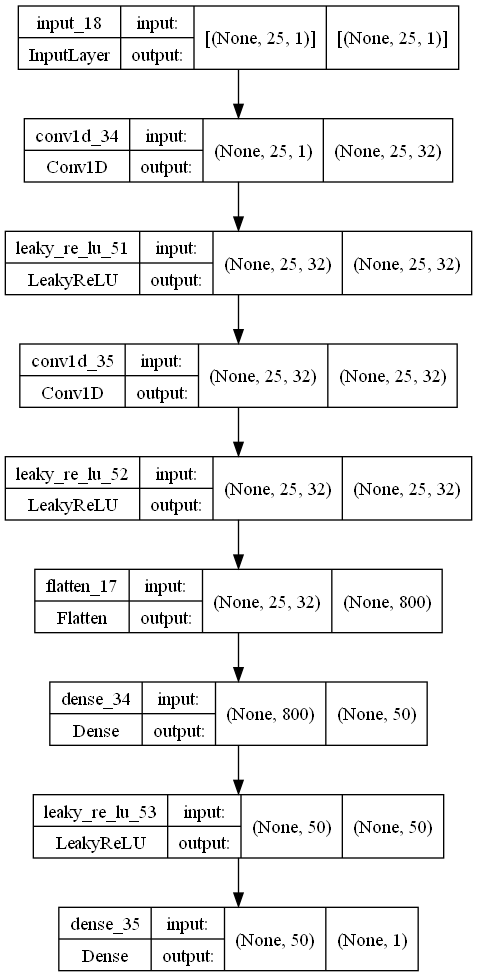

In [189]:
# Plot the model
# plot_model(model, show_shapes=True, show_layer_names=True)

In [190]:
# X, y = create_synthetic_dataset()
# print(X.shape)
# print(y.shape)

(50000, 25, 1)
(50000, 1)


In [191]:
# # Generate an array of indices
# indices = np.arange(X.shape[0])
# # Shuffle the indices
# np.random.shuffle(indices)
# # Use the shuffled indices to reorder X and y
# X_shuffled = X[indices]
# y_shuffled = y[indices]
# 
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=seed_value)

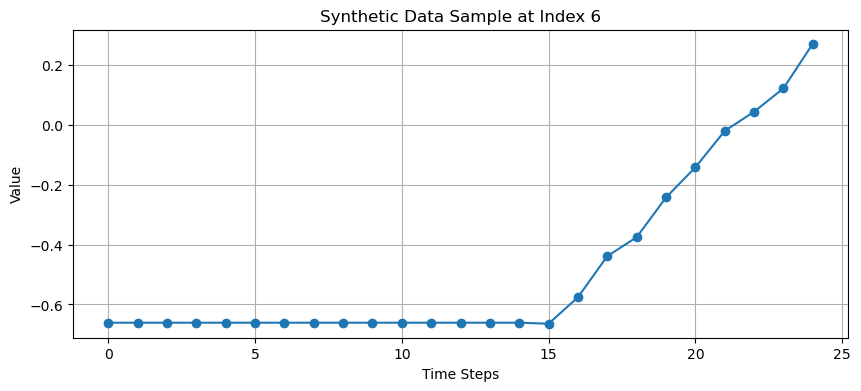

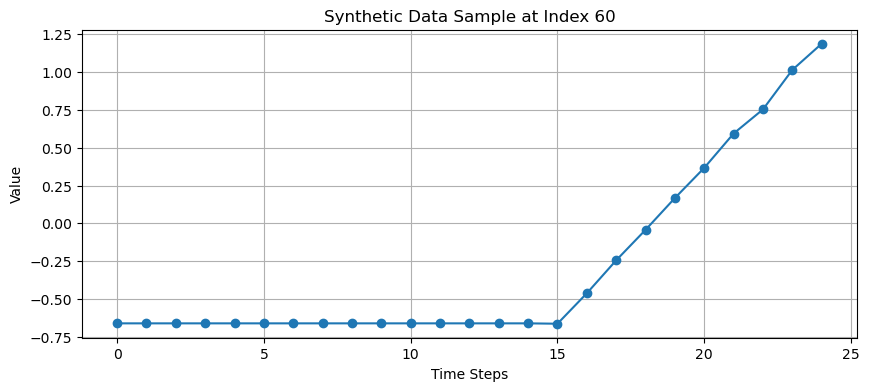

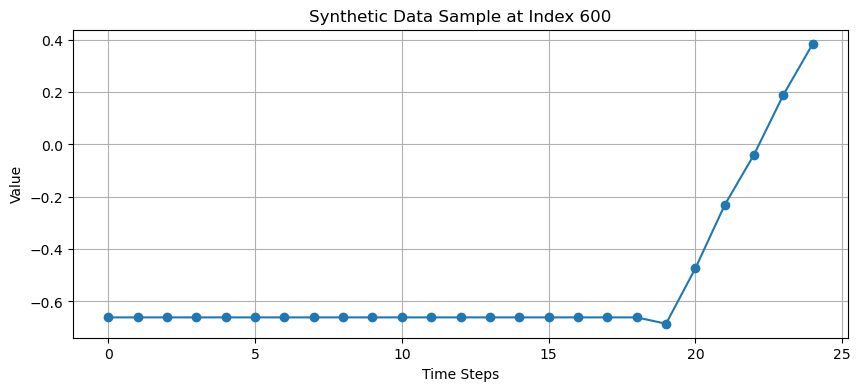

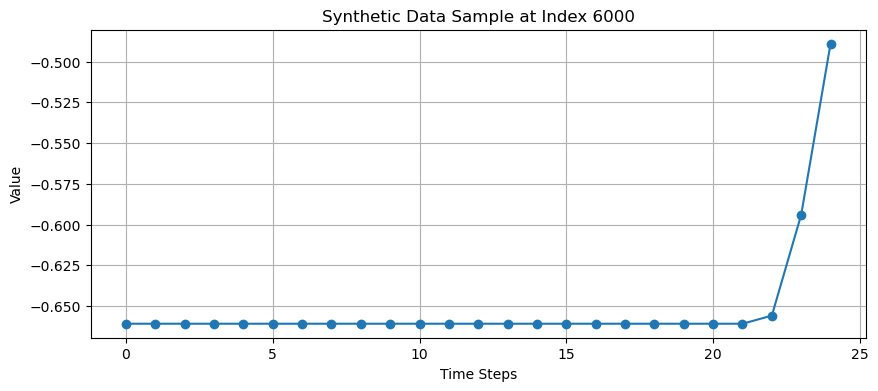

In [192]:
# plot_sample(X, 6)
# plot_sample(X, 60)
# plot_sample(X, 600)
# plot_sample(X, 6000)

### before training

filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)


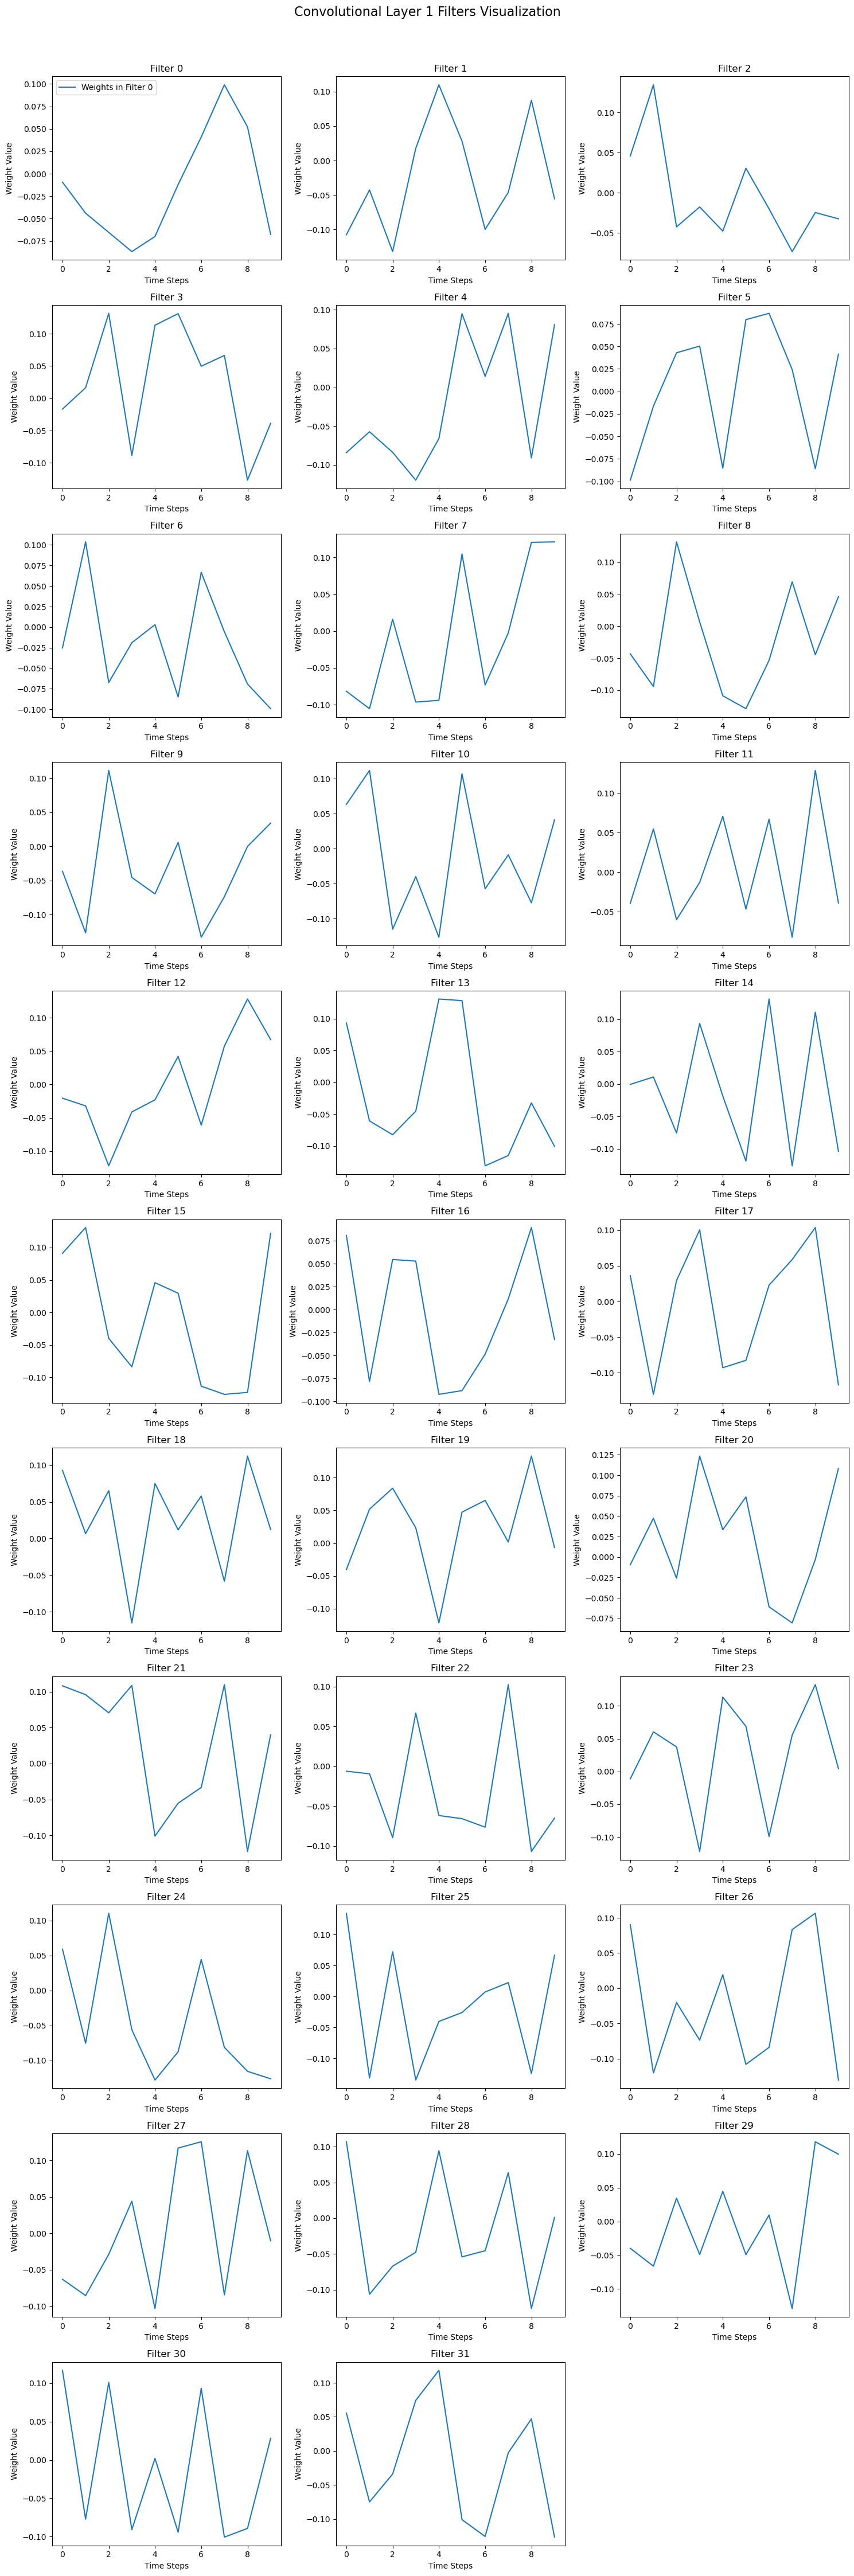

In [194]:
# # Plot filters of the first convolutional layer
# plot_conv1d_filters(model, layer_index=1)
# 
# # Plot filters of the second convolutional layer
# # plot_conv1d_filters(model, layer_index=3)

Epoch 1/1000
1250/1250 [==============================] - 6s 4ms/step - loss: 0.1026 - val_loss: 0.0293
Epoch 2/1000
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0254 - val_loss: 0.0191
Epoch 3/1000
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0225 - val_loss: 0.0150
Epoch 4/1000
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0198 - val_loss: 0.0162
Epoch 5/1000
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0184 - val_loss: 0.0146
Epoch 6/1000
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0185 - val_loss: 0.0157
Epoch 7/1000
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0172 - val_loss: 0.0125
Epoch 8/1000
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0172 - val_loss: 0.0157
Epoch 9/1000
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0168 - val_loss: 0.0163
Epoch 10/1000
1250/1250 [==============================] - 5s 4m

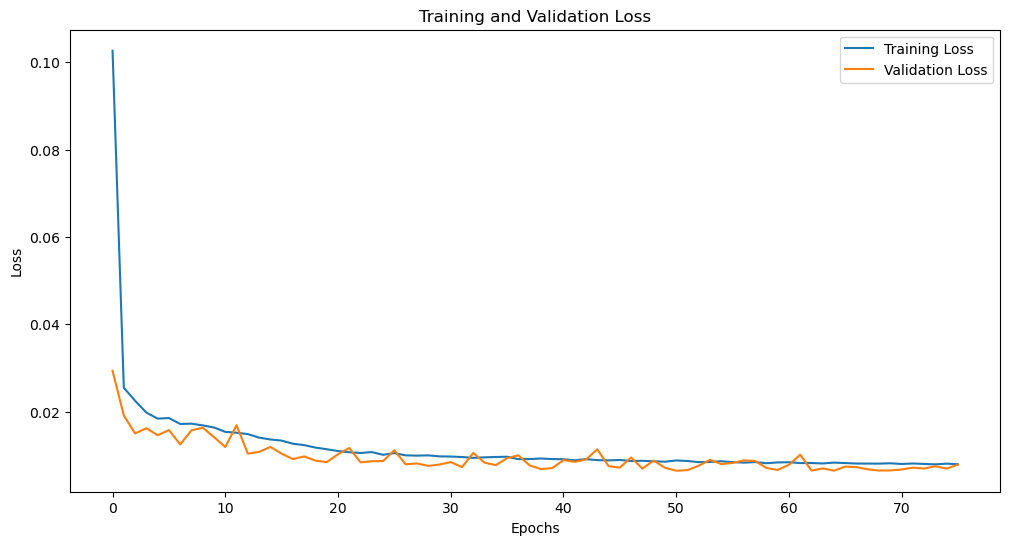

Epoch 1/51
1563/1563 [==============================] - 8s 4ms/step - loss: 0.1016
Epoch 2/51
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0246
Epoch 3/51
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0204
Epoch 4/51
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0194
Epoch 5/51
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0179
Epoch 6/51
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0173
Epoch 7/51
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0165
Epoch 8/51
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0159
Epoch 9/51
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0152
Epoch 10/51
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0139
Epoch 11/51
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0141
Epoch 12/51
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0128
E

In [195]:
# # Set the early stopping patience and learning rate as variables
# patience = 25
# learning_rate = 1e-3
# 
# # Define the EarlyStopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)
# 
# # Compile the model with the specified learning rate
# model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
# 
# # Train the model with the callback
# history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test),
#                     callbacks=[early_stopping])
# 
# # Plot the training and validation loss
# plt.figure(figsize=(12, 6))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()
# 
# # Determine the optimal number of epochs from early stopping
# optimal_epochs = early_stopping.stopped_epoch - patience + 1  # Adjust for the offset
# 
# # Retrain the model on the full dataset
# full_X = np.concatenate((X_train, X_test))
# full_y = np.concatenate((y_train, y_test))
# 
# final_model = create_cnn()  # Recreate the model architecture
# final_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')  # Compile the model just like before
# 
# # Train on the full dataset
# final_model.fit(full_X, full_y, epochs=optimal_epochs, batch_size=32, verbose=1)

### After training

filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)
filter shape: (10, 1, 32)


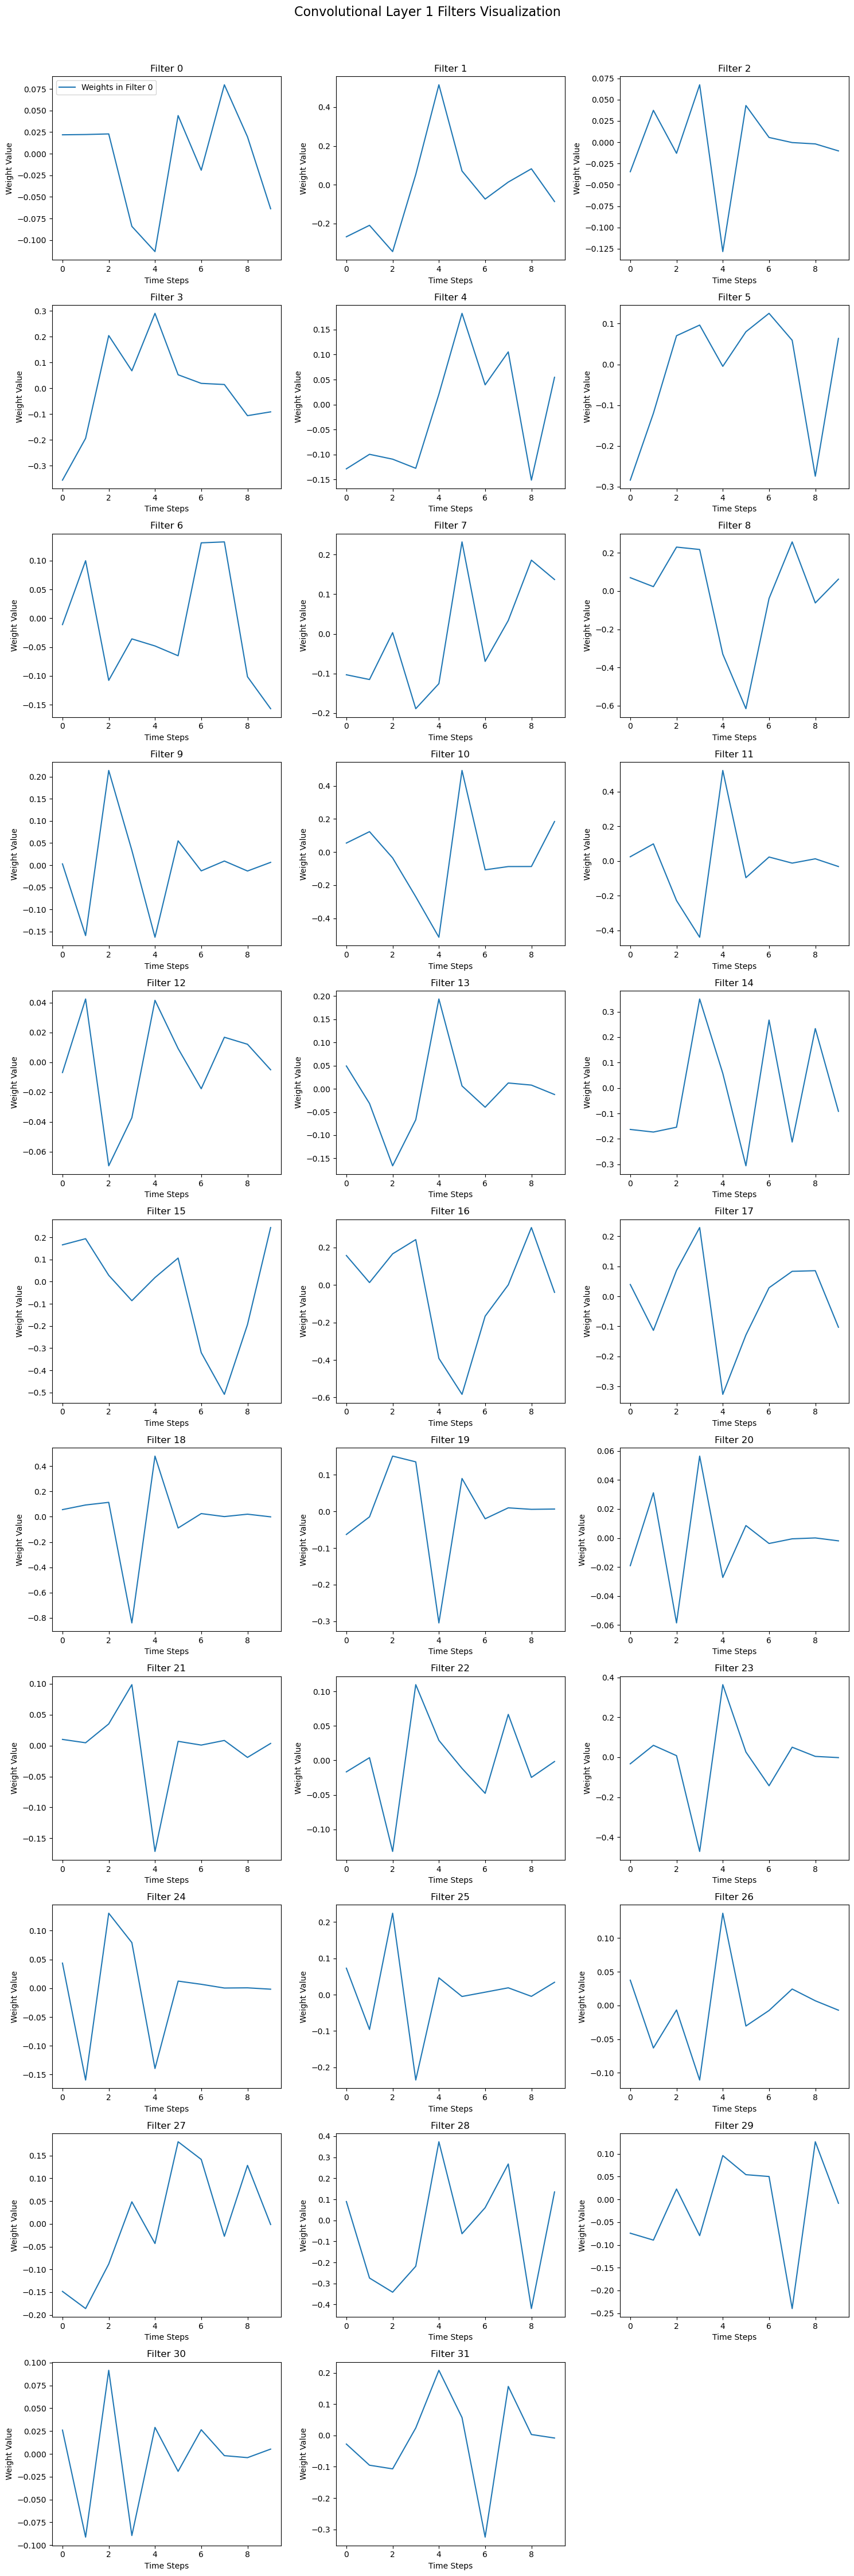

In [196]:
# # Plot filters of the first convolutional layer
# plot_conv1d_filters(model, layer_index=1)
# 
# # Plot filters of the second convolutional layer
# # plot_conv1d_filters(model, layer_index=3)

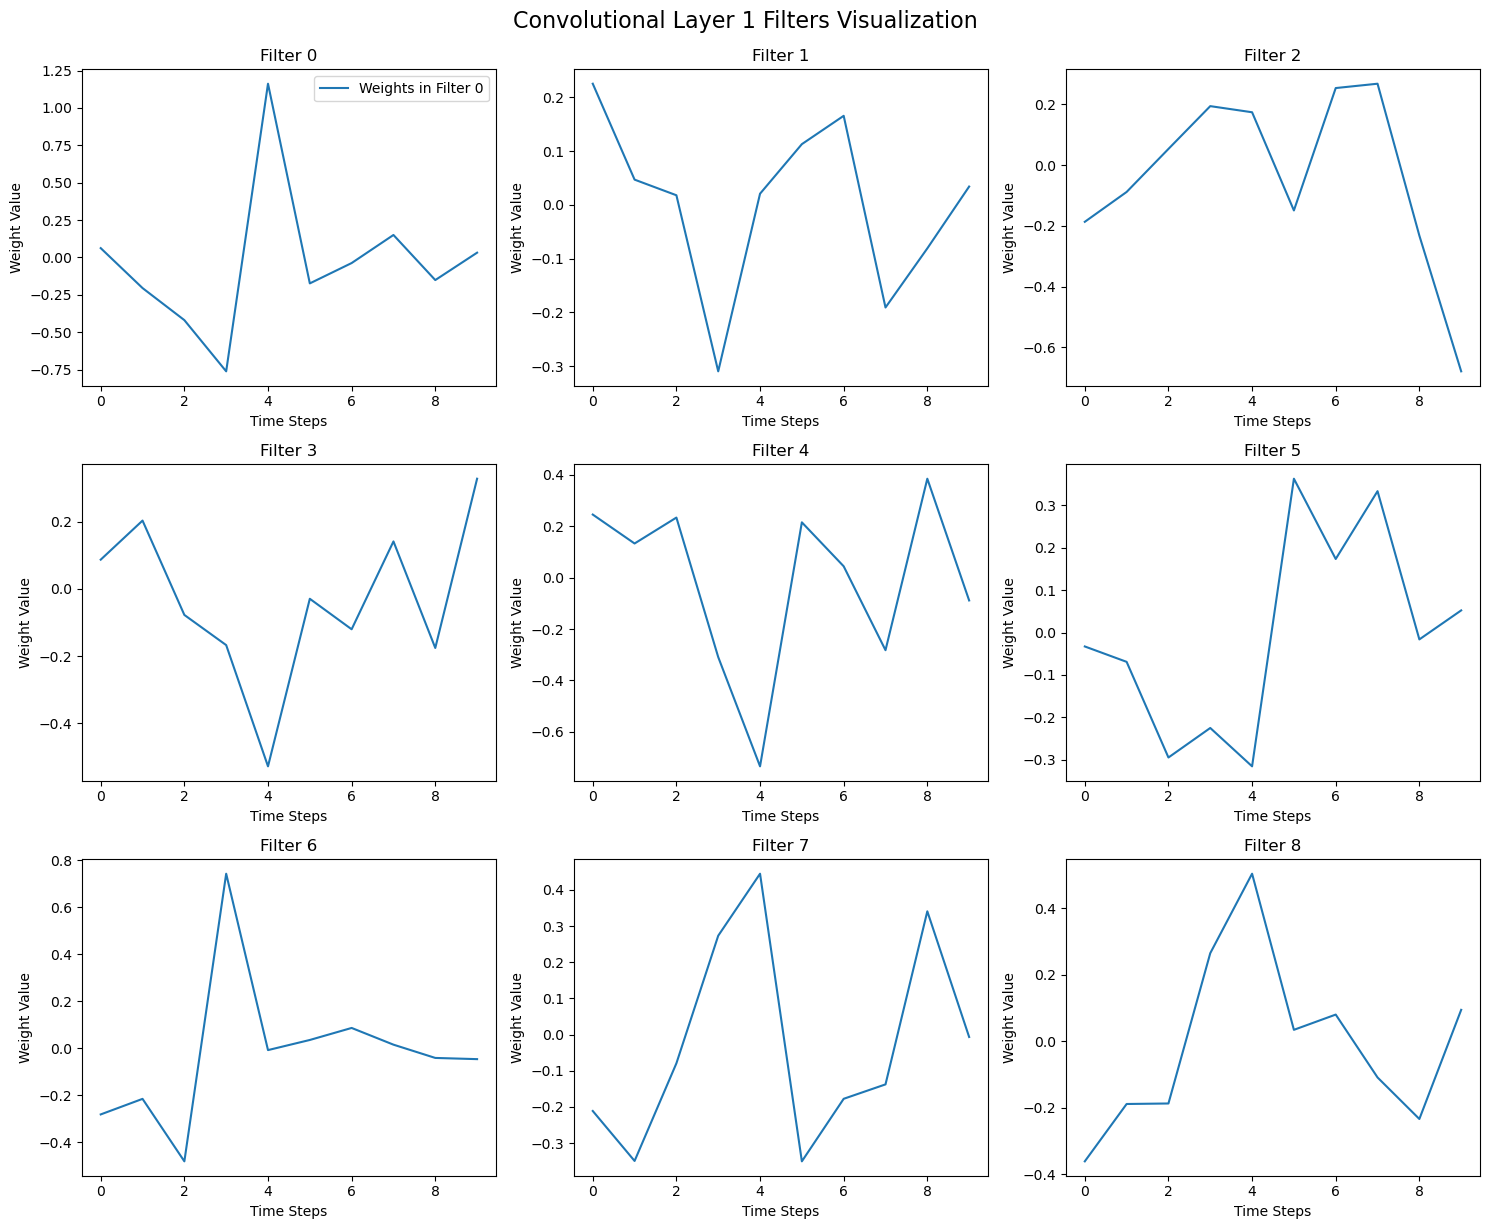

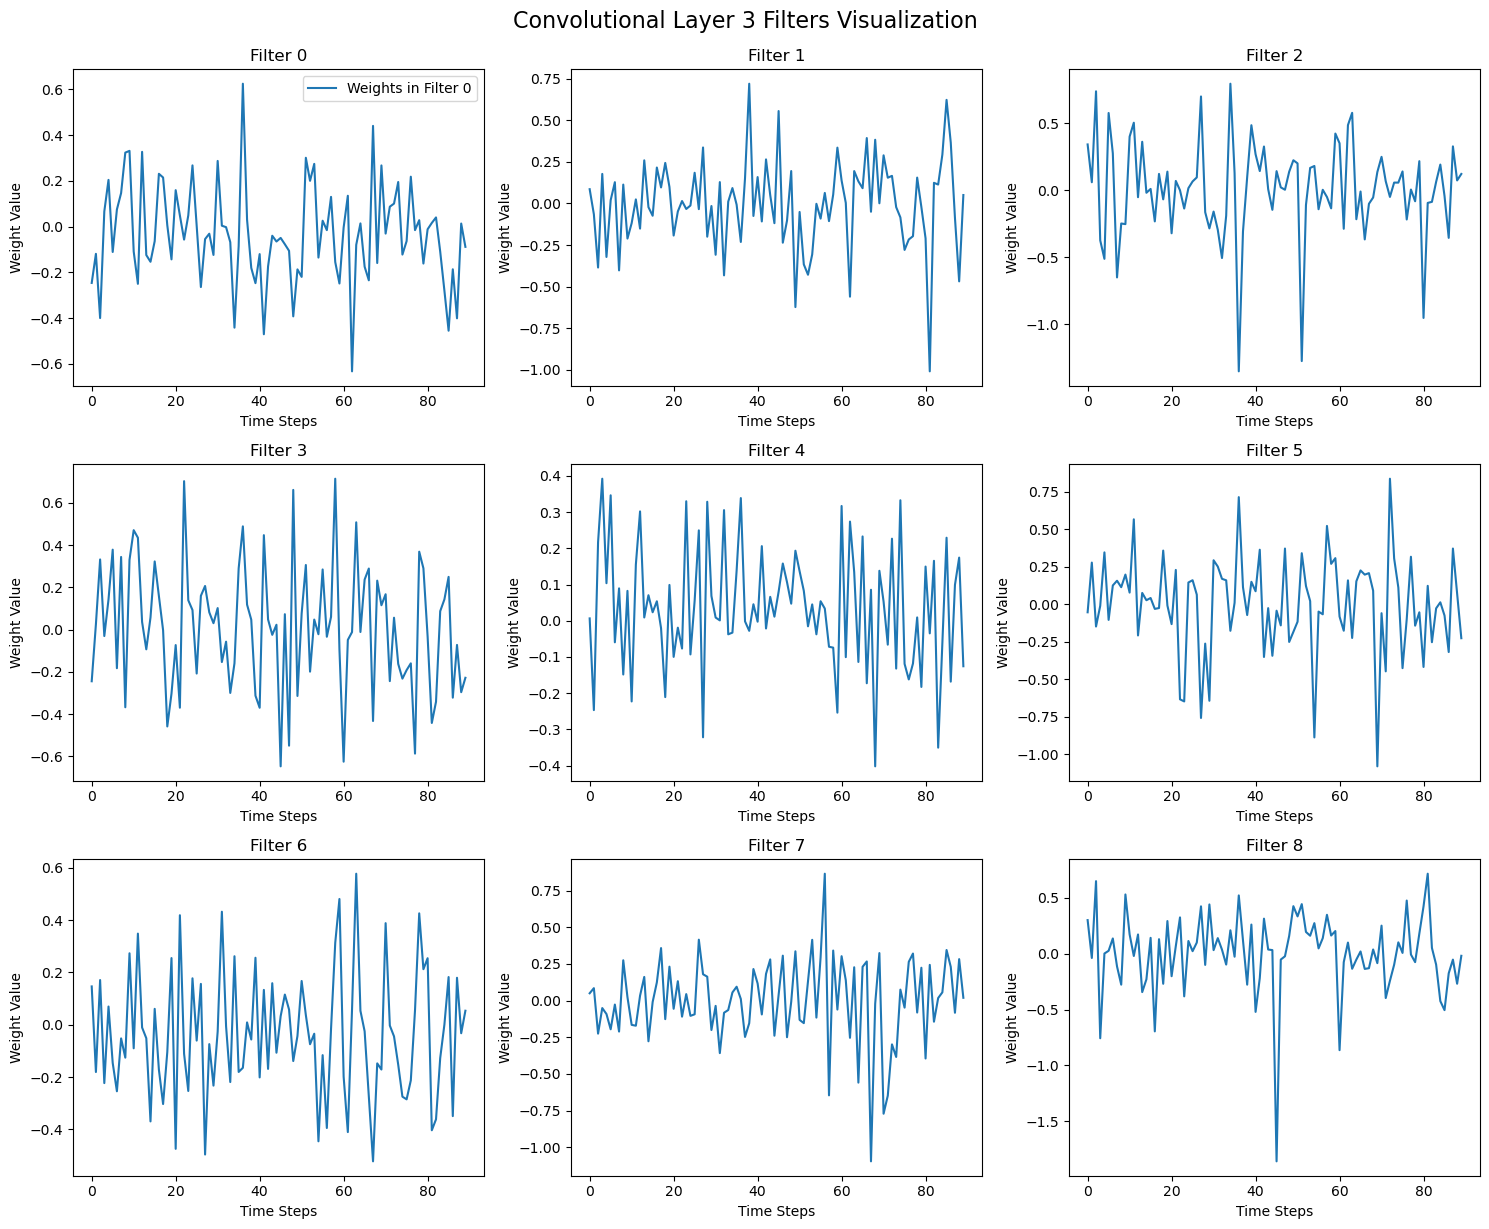

In [169]:
# # Plot filters of the first convolutional layer
# plot_conv1d_filters(final_model, layer_index=1)
# 
# # Plot filters of the second convolutional layer
# plot_conv1d_filters(final_model, layer_index=3)

In [118]:
# X_testing, y_testing = create_synthetic_dataset(n_samples=10000)
# print(X_testing.shape)
# print(y_testing.shape)


(10000, 25, 1)
(10000, 1)


In [119]:
# error = evaluate_model(final_model, X_test, y_test)
# print(f'mae error: {error}')

mae error: 0.04408179751281459


# more SEP data once cleaned up

In [18]:
X_train, y_train = build_dataset('D:/College/Fall2023/electron_cme_data_split_12h/training')
X_subtrain, y_subtrain = build_dataset('D:/College/Fall2023/electron_cme_data_split_12h/subtraining')
X_test, y_test = build_dataset('D:/College/Fall2023/electron_cme_data_split_12h/testing')
X_val, y_val = build_dataset('D:/College/Fall2023/electron_cme_data_split_12h/validation')

In [19]:
# print all data shapes 
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_subtrain.shape: {X_subtrain.shape}')
print(f'y_subtrain.shape: {y_subtrain.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_val.shape: {y_val.shape}')


X_train.shape: (13491, 25, 1)
y_train.shape: (13491,)
X_subtrain.shape: (9221, 25, 1)
y_subtrain.shape: (9221,)
X_test.shape: (9042, 25, 1)
y_test.shape: (9042,)
X_val.shape: (4270, 25, 1)
y_val.shape: (4270,)


In [20]:
# print a sample of the training data
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')

X_train[0]: [[0.39444655]
 [0.3961764 ]
 [0.39788353]
 [0.39956855]
 [0.401232  ]
 [0.40287444]
 [0.4044964 ]
 [0.40609836]
 [0.40768084]
 [0.40924428]
 [0.41078915]
 [0.41231587]
 [0.41232932]
 [0.41382482]
 [0.41530336]
 [0.41676532]
 [0.41821106]
 [0.41964094]
 [0.42105531]
 [0.4224545 ]
 [0.42383883]
 [0.42520861]
 [0.42656414]
 [0.42790573]
 [0.25048113]]
y_train[0]: 0.027264911148012706


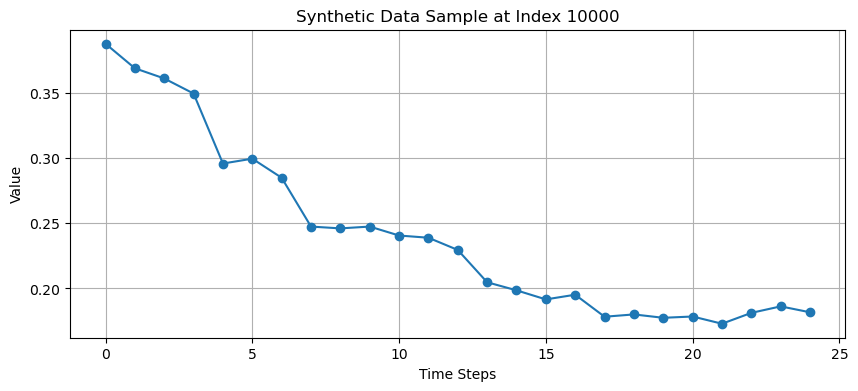

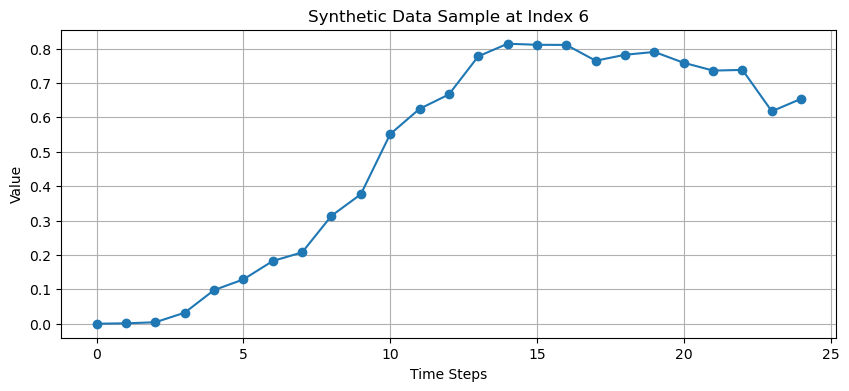

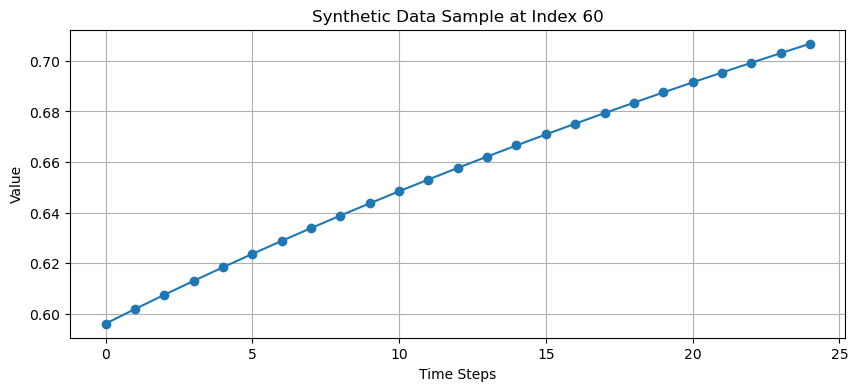

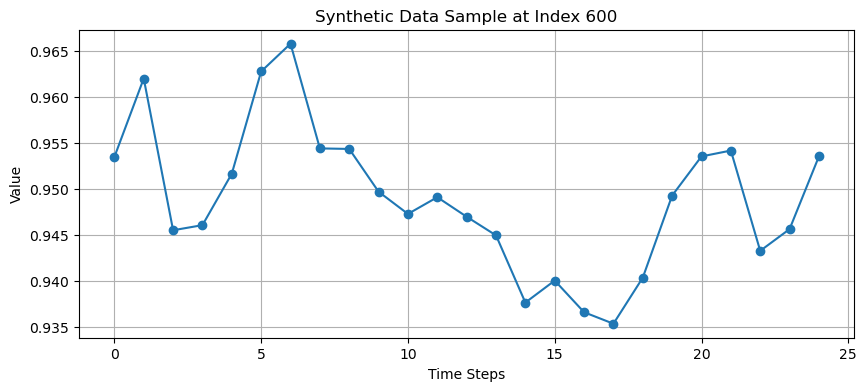

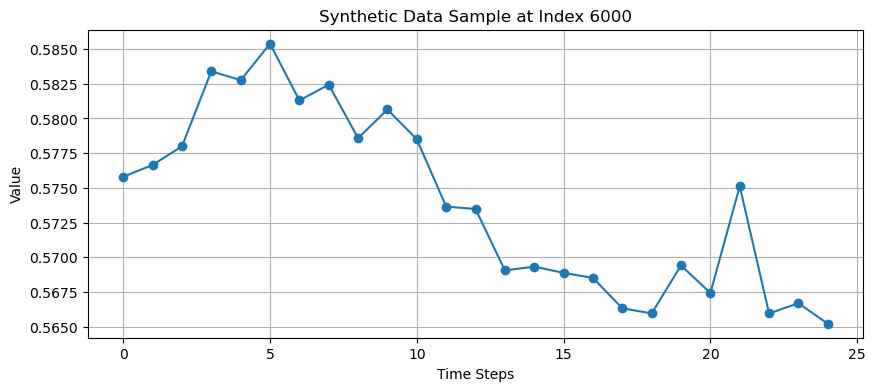

In [21]:
# plot a training sample 
plot_sample(X_train, 10000)
plot_sample(X_train, 6)
plot_sample(X_train, 60)
plot_sample(X_train, 600)
plot_sample(X_train, 6000)

In [22]:
# create the model 
model_sep = create_cnn()
model_sep.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 25, 32)            352       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 25, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            10272     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 25, 32)            0         
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 50)                40050 

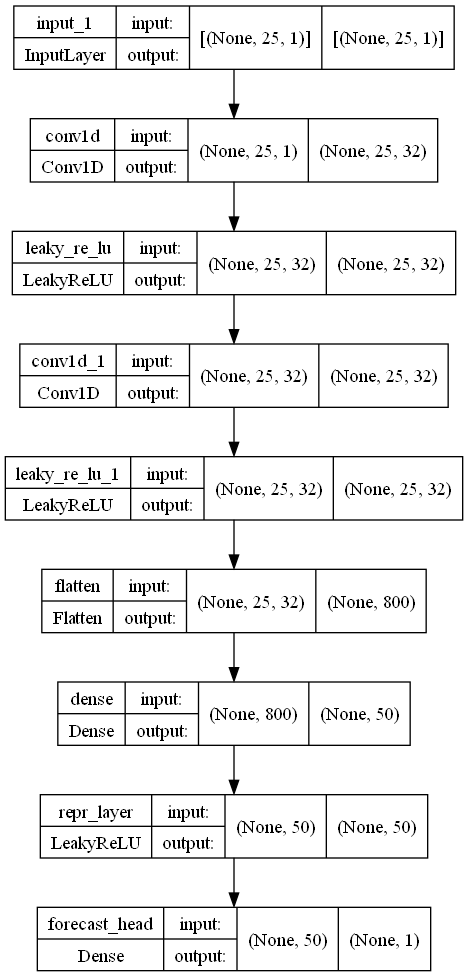

In [23]:
# Plot the model
plot_model(model_sep, show_shapes=True, show_layer_names=True)

### before training

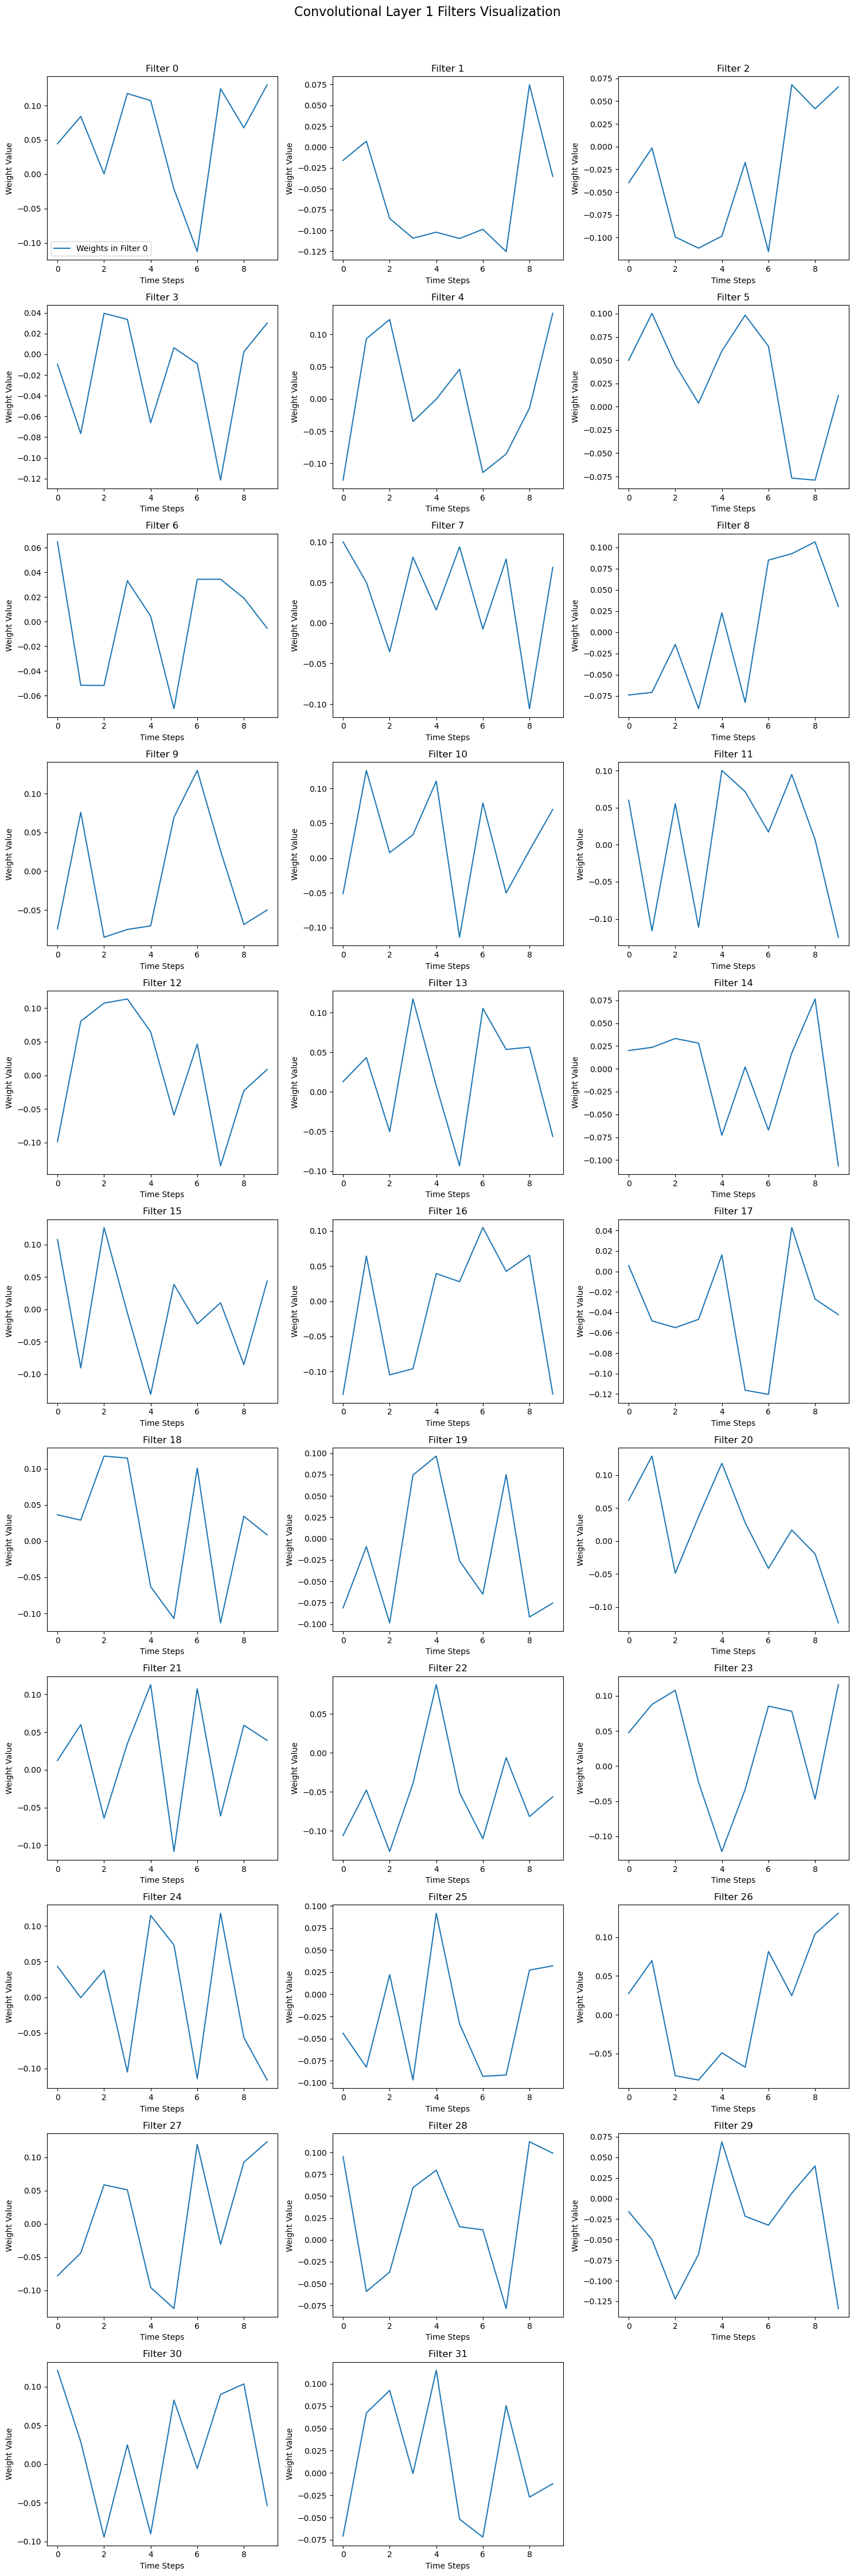

In [24]:
# Plot filters of the first convolutional layer
plot_conv1d_filters(model_sep, layer_index=1)

Epoch 1/1000
289/289 [==============================] - 2s 4ms/step - loss: 0.6447 - forecast_head_loss: 0.6447 - val_loss: 1.4097 - val_forecast_head_loss: 1.4097
Epoch 2/1000
289/289 [==============================] - 1s 3ms/step - loss: 0.6055 - forecast_head_loss: 0.6055 - val_loss: 1.3707 - val_forecast_head_loss: 1.3707
Epoch 3/1000
289/289 [==============================] - 1s 3ms/step - loss: 0.5990 - forecast_head_loss: 0.5990 - val_loss: 1.3754 - val_forecast_head_loss: 1.3754
Epoch 4/1000
289/289 [==============================] - 1s 3ms/step - loss: 0.5943 - forecast_head_loss: 0.5943 - val_loss: 1.4777 - val_forecast_head_loss: 1.4777
Epoch 5/1000
289/289 [==============================] - 1s 4ms/step - loss: 0.5912 - forecast_head_loss: 0.5912 - val_loss: 1.6175 - val_forecast_head_loss: 1.6175
Epoch 6/1000
289/289 [==============================] - 1s 3ms/step - loss: 0.5767 - forecast_head_loss: 0.5767 - val_loss: 1.1826 - val_forecast_head_loss: 1.1826
Epoch 7/1000
289

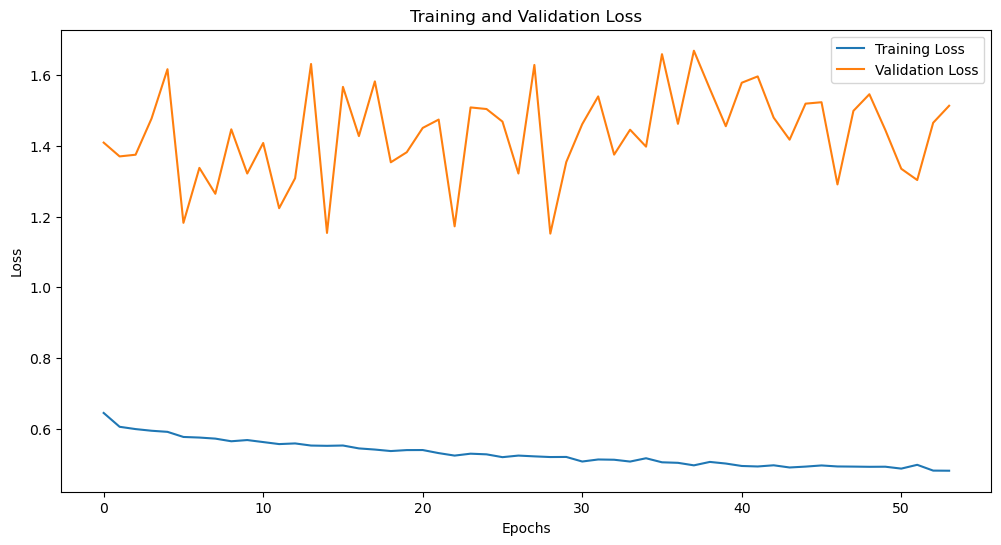

Epoch 1/29
422/422 [==============================] - 2s 3ms/step - loss: 0.8307 - forecast_head_loss: 0.8307
Epoch 2/29
422/422 [==============================] - 1s 3ms/step - loss: 0.7938 - forecast_head_loss: 0.7938
Epoch 3/29
422/422 [==============================] - 1s 3ms/step - loss: 0.7822 - forecast_head_loss: 0.7822
Epoch 4/29
422/422 [==============================] - 1s 3ms/step - loss: 0.7696 - forecast_head_loss: 0.7696
Epoch 5/29
422/422 [==============================] - 1s 3ms/step - loss: 0.7501 - forecast_head_loss: 0.7501
Epoch 6/29
422/422 [==============================] - 1s 3ms/step - loss: 0.7339 - forecast_head_loss: 0.7339
Epoch 7/29
422/422 [==============================] - 1s 3ms/step - loss: 0.7033 - forecast_head_loss: 0.7033
Epoch 8/29
422/422 [==============================] - 1s 3ms/step - loss: 0.6985 - forecast_head_loss: 0.6985
Epoch 9/29
422/422 [==============================] - 1s 3ms/step - loss: 0.6834 - forecast_head_loss: 0.6834
Epoch 10/2

In [25]:
# Set the early stopping patience and learning rate as variables
patience = 25
learning_rate = 3e-3

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_forecast_head_loss', patience=patience, verbose=1, restore_best_weights=True)

# Compile the model with the specified learning rate
model_sep.compile(optimizer=Adam(learning_rate=learning_rate), loss={'forecast_head': 'mse'})

# Train the model with the callback
history = model_sep.fit(X_subtrain,
                        {'forecast_head': y_subtrain}, 
                        epochs=1000, batch_size=32, 
                        validation_data=(X_val, {'forecast_head': y_val}),
                        callbacks=[early_stopping])

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Determine the optimal number of epochs from early stopping
optimal_epochs = early_stopping.stopped_epoch - patience + 1  # Adjust for the offset
final_model_sep = create_cnn()  # Recreate the model architecture
final_model_sep.compile(optimizer=Adam(learning_rate=learning_rate), loss={'forecast_head': 'mse'})  # Compile the model just like before
# Train on the full dataset
final_model_sep.fit(X_train, {'forecast_head': y_train}, epochs=optimal_epochs, batch_size=32, verbose=1)

### After training

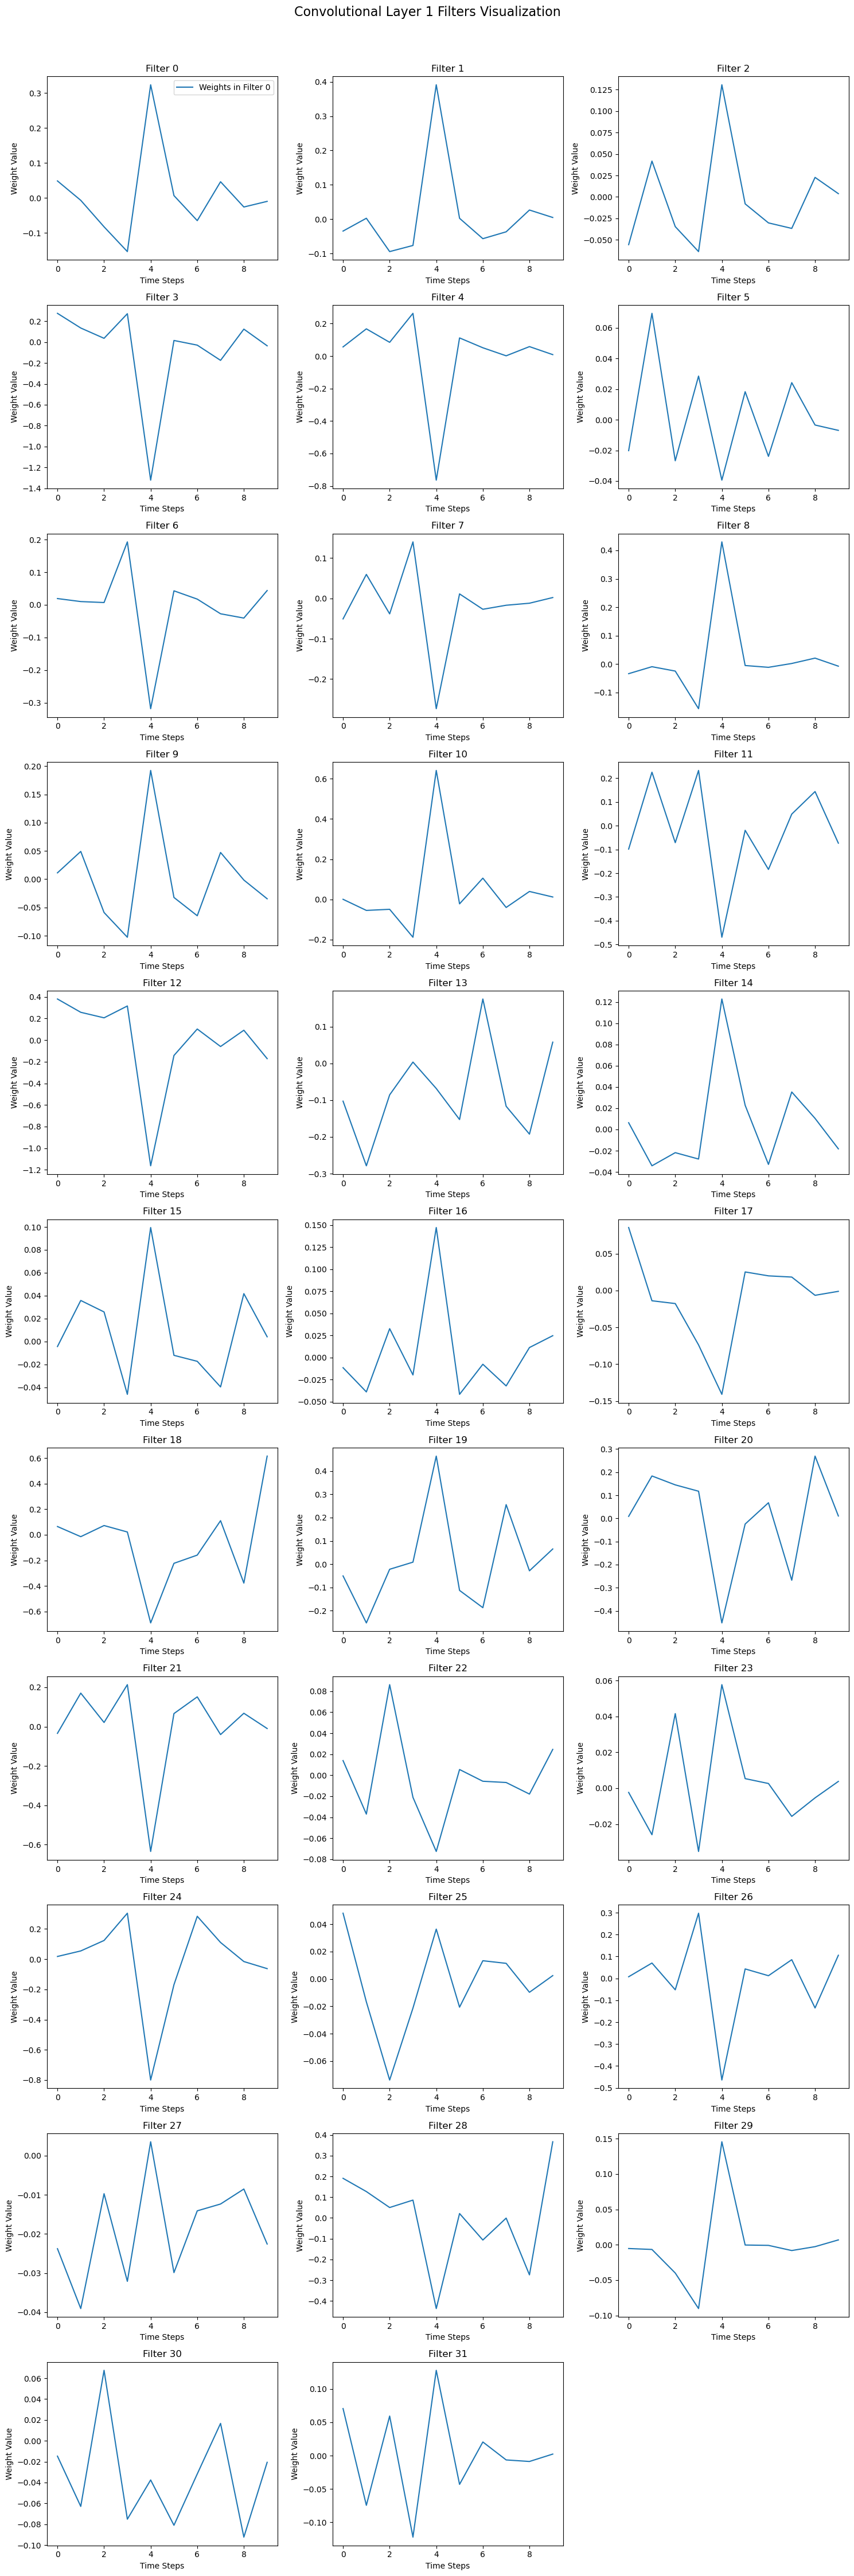

In [26]:
# Plot filters of the first convolutional layer
plot_conv1d_filters(final_model_sep, layer_index=1)

In [27]:
# evaluate the model on test data
error_mae = evaluate_model(final_model_sep, X_test, y_test)
print(f'mae error: {error_mae}')

mae error: 0.7173124072392572


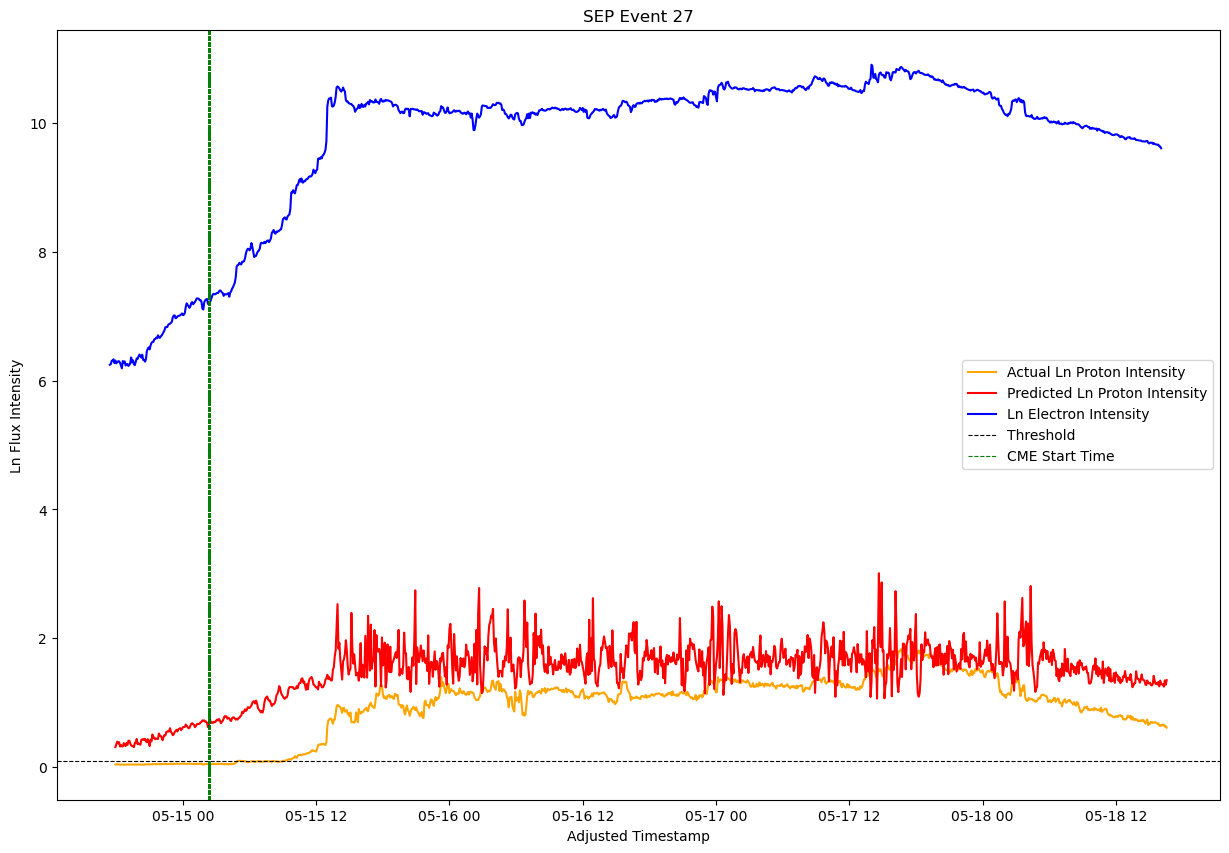

Saved plot to: C:\Users\the_3\OneDrive\Desktop\school\Fall 2023\keras-functional-api\notebooks\Y_SEP_Event_27_MAE_0.5538.png
Processed file: sep_event_27_filled_ie.csv with MAE: 0.5537820028328071


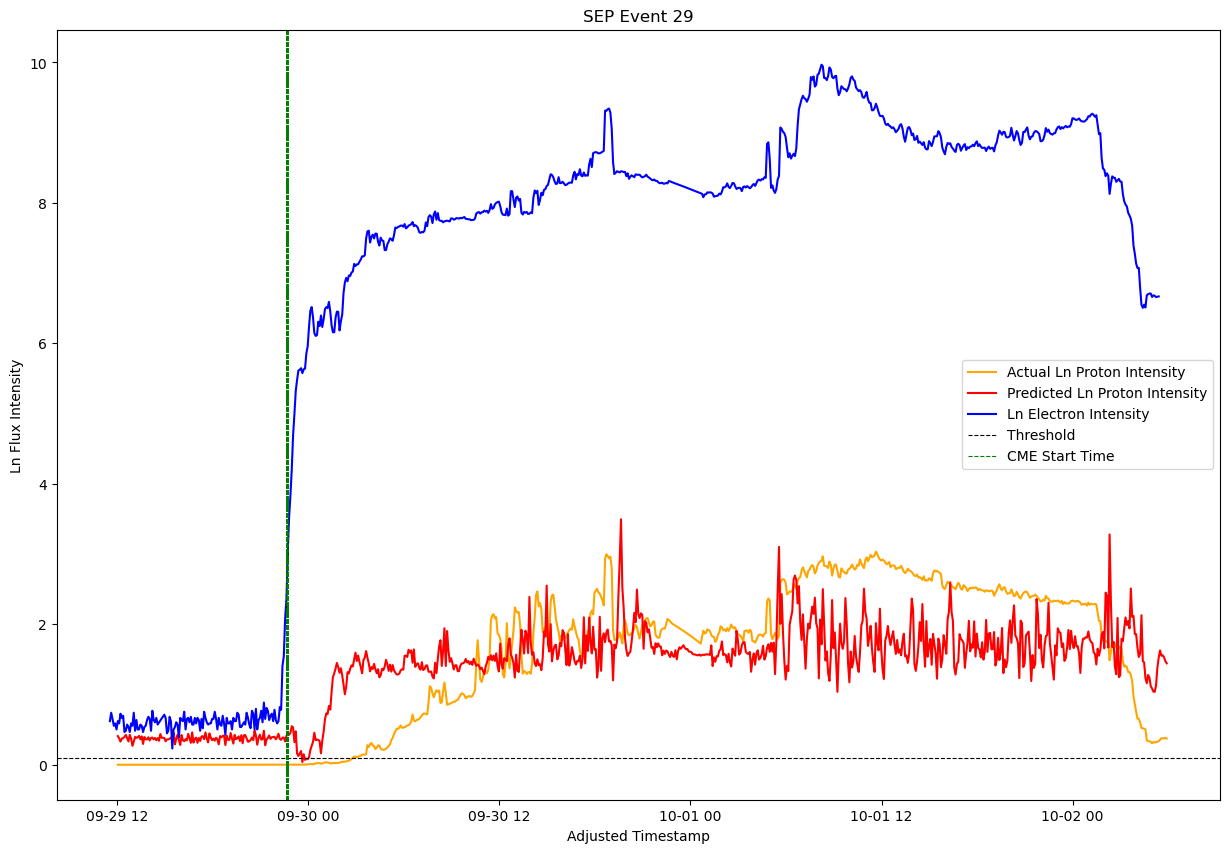

Saved plot to: C:\Users\the_3\OneDrive\Desktop\school\Fall 2023\keras-functional-api\notebooks\Y_SEP_Event_29_MAE_0.6125.png
Processed file: sep_event_29_filled_ie.csv with MAE: 0.6124637517943481


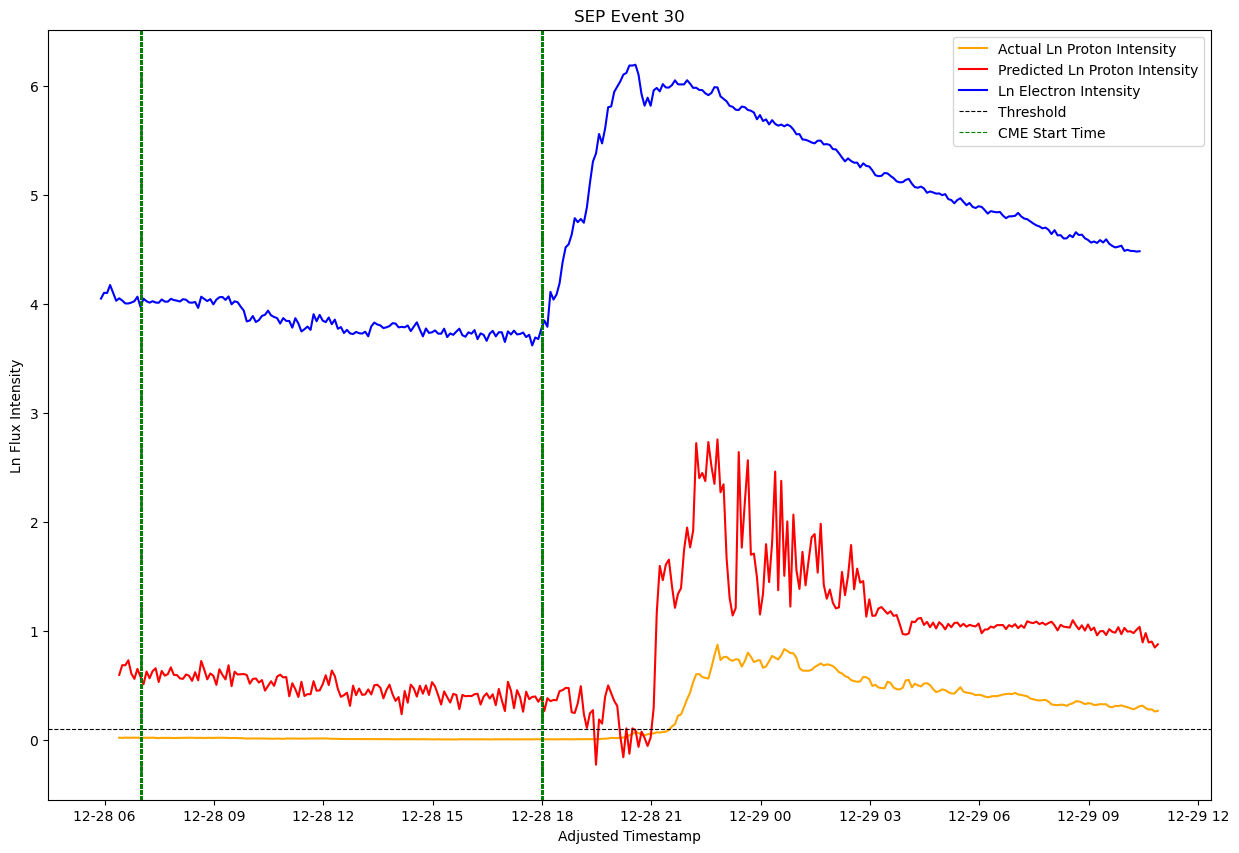

Saved plot to: C:\Users\the_3\OneDrive\Desktop\school\Fall 2023\keras-functional-api\notebooks\Y_SEP_Event_30_MAE_0.6354.png
Processed file: sep_event_30_filled_ie.csv with MAE: 0.635437980712363


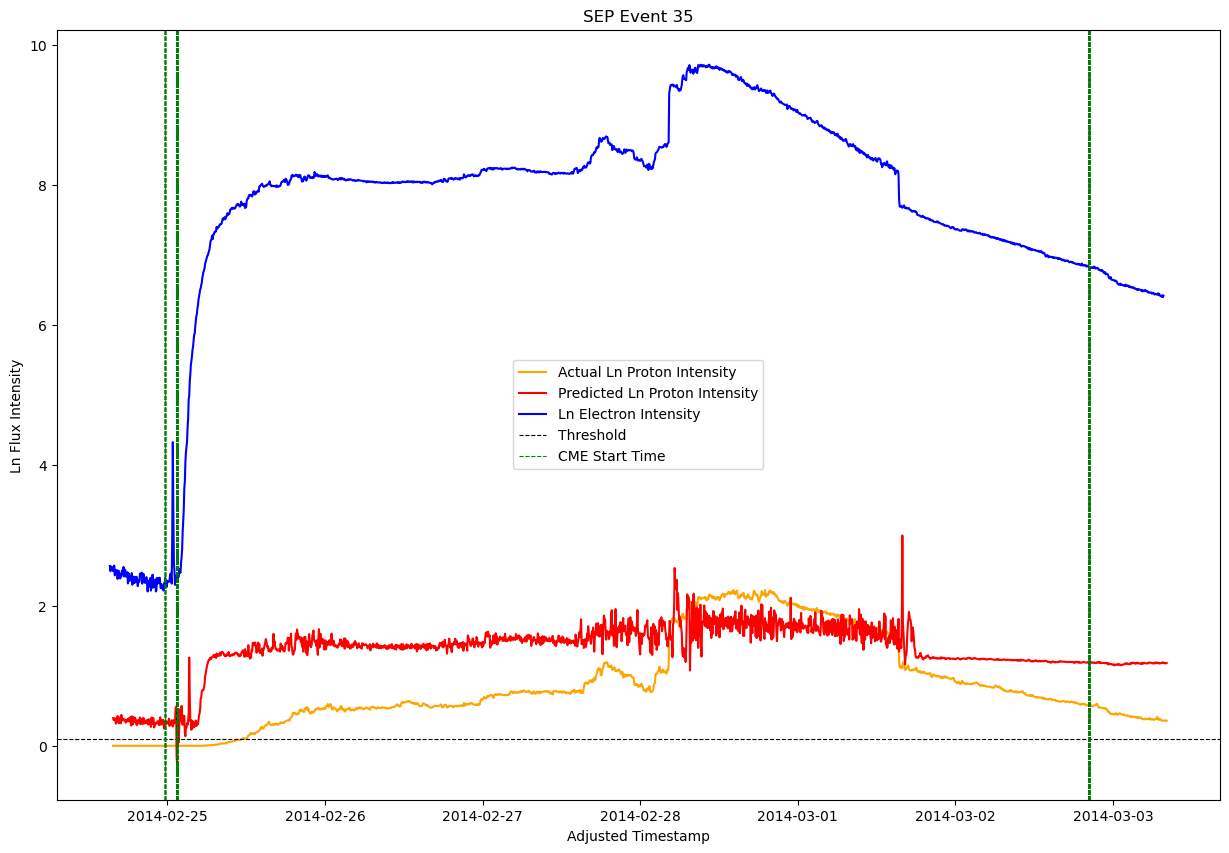

Saved plot to: C:\Users\the_3\OneDrive\Desktop\school\Fall 2023\keras-functional-api\notebooks\Y_SEP_Event_35_MAE_0.6052.png
Processed file: sep_event_35_filled_ie.csv with MAE: 0.6051575581195909


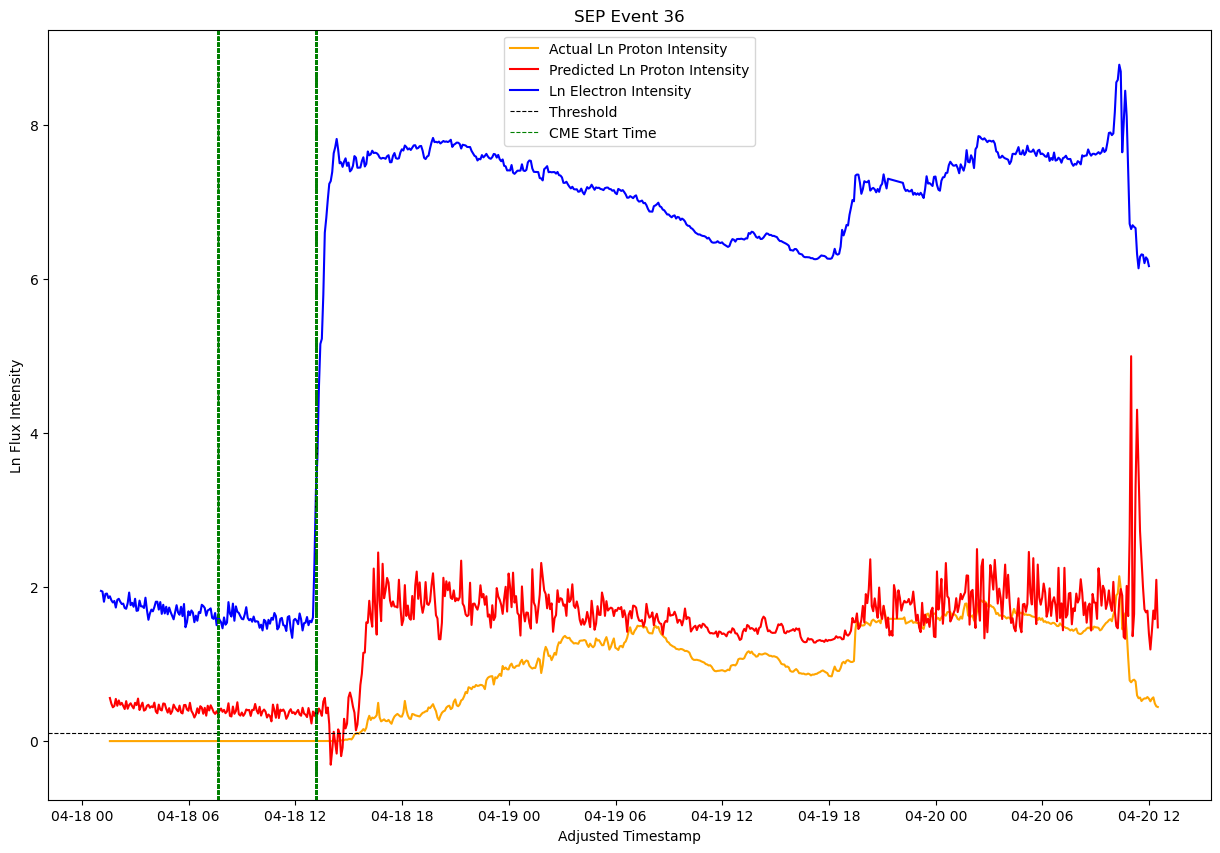

Saved plot to: C:\Users\the_3\OneDrive\Desktop\school\Fall 2023\keras-functional-api\notebooks\Y_SEP_Event_36_MAE_0.5359.png
Processed file: sep_event_36_filled_ie.csv with MAE: 0.5359400374926488


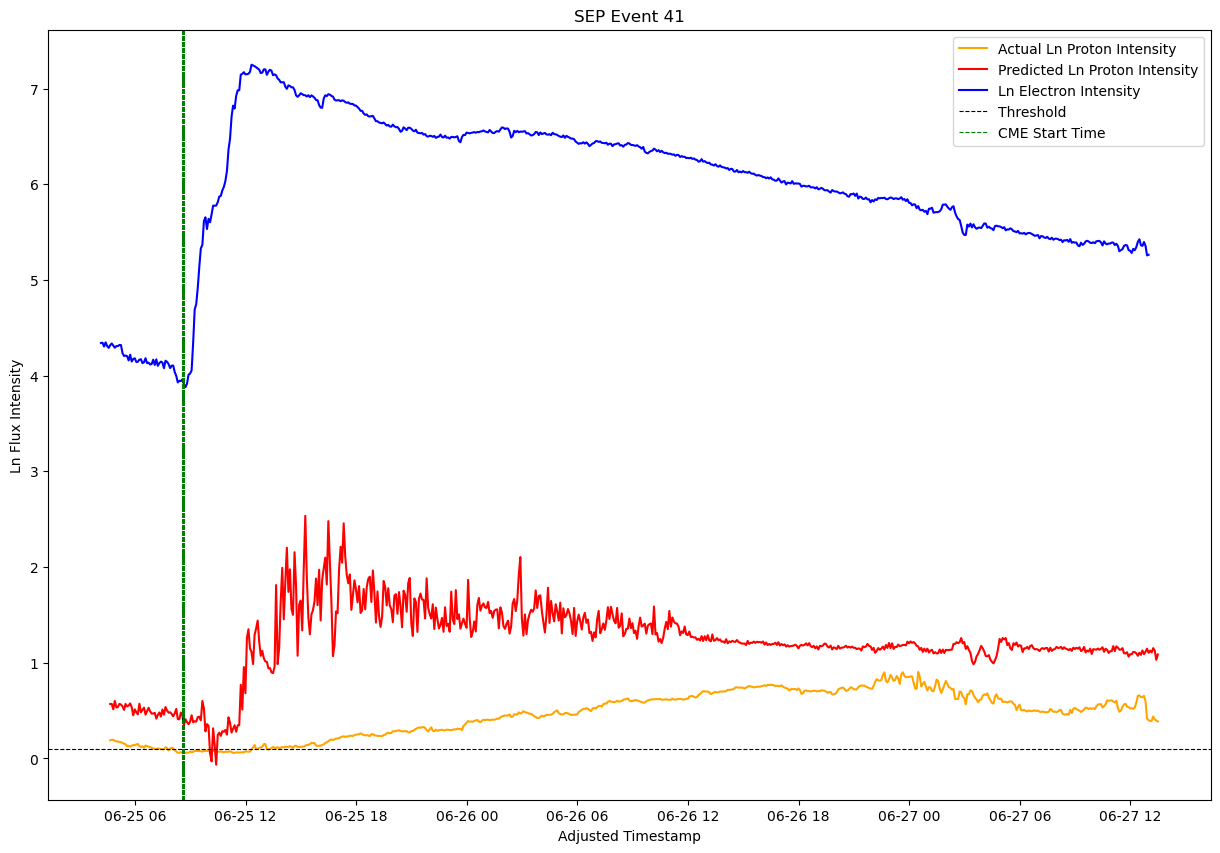

Saved plot to: C:\Users\the_3\OneDrive\Desktop\school\Fall 2023\keras-functional-api\notebooks\Y_SEP_Event_41_MAE_0.7560.png
Processed file: sep_event_41_filled_ie.csv with MAE: 0.7559660417112907


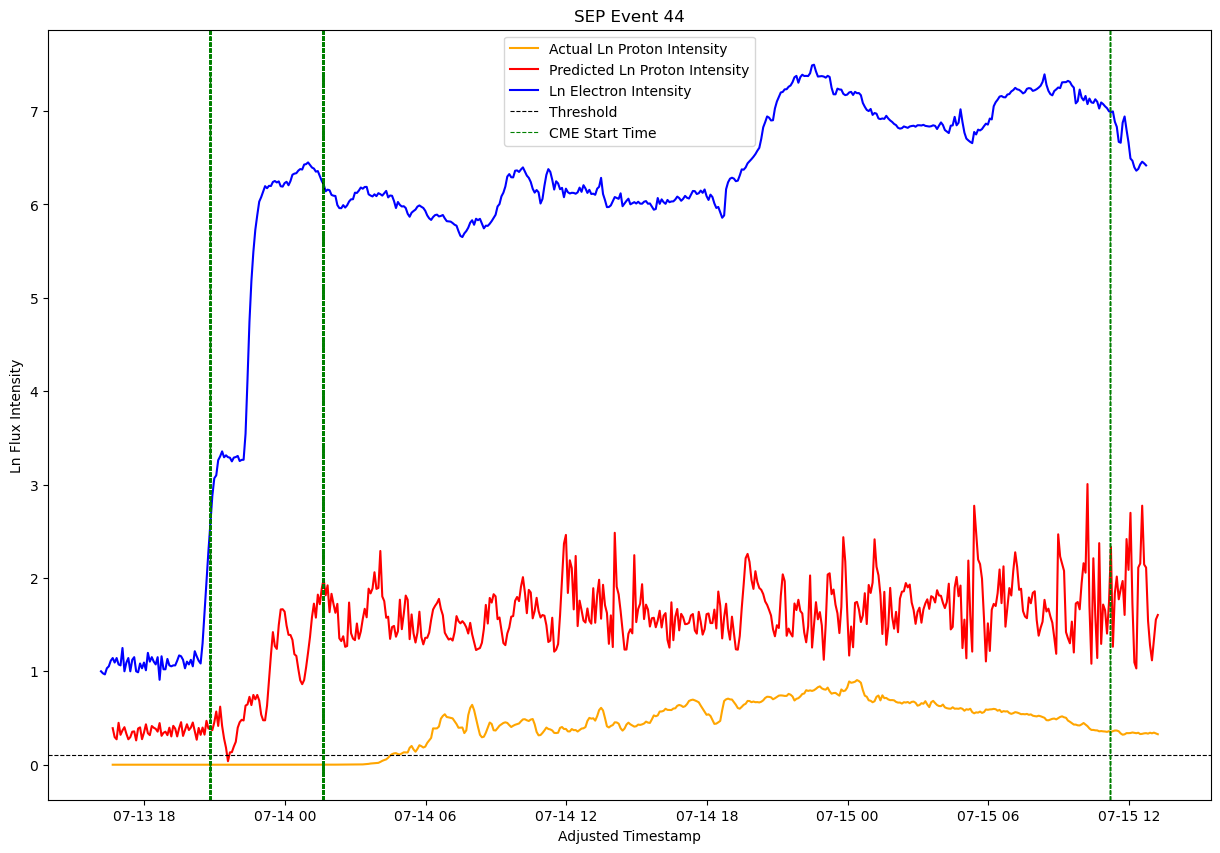

Saved plot to: C:\Users\the_3\OneDrive\Desktop\school\Fall 2023\keras-functional-api\notebooks\Y_SEP_Event_44_MAE_1.0732.png
Processed file: sep_event_44_filled_ie.csv with MAE: 1.0732128837804733


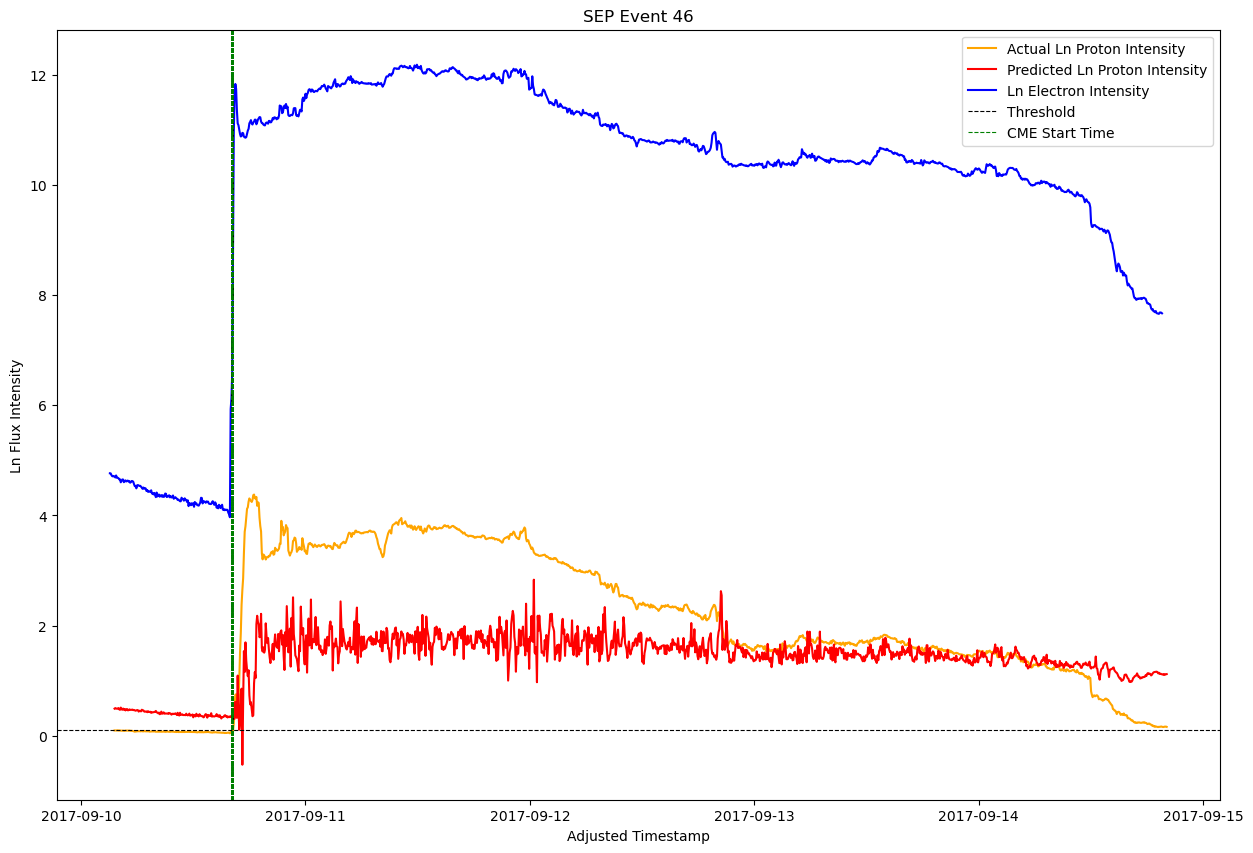

Saved plot to: C:\Users\the_3\OneDrive\Desktop\school\Fall 2023\keras-functional-api\notebooks\Y_SEP_Event_46_MAE_0.8613.png
Processed file: sep_event_46_filled_ie.csv with MAE: 0.8612623669608579


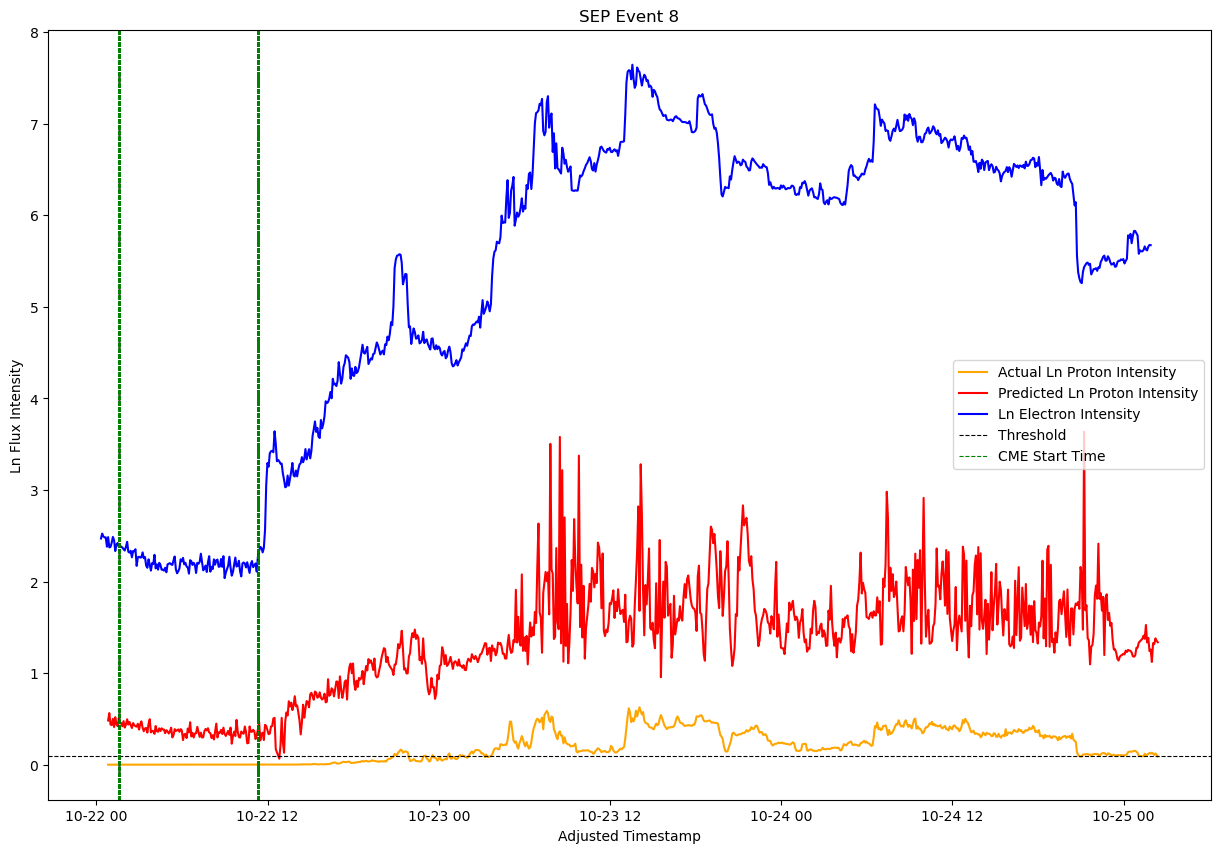

Saved plot to: C:\Users\the_3\OneDrive\Desktop\school\Fall 2023\keras-functional-api\notebooks\Y_SEP_Event_8_MAE_1.1289.png
Processed file: sep_event_8_filled_ie.csv with MAE: 1.1289495393082771


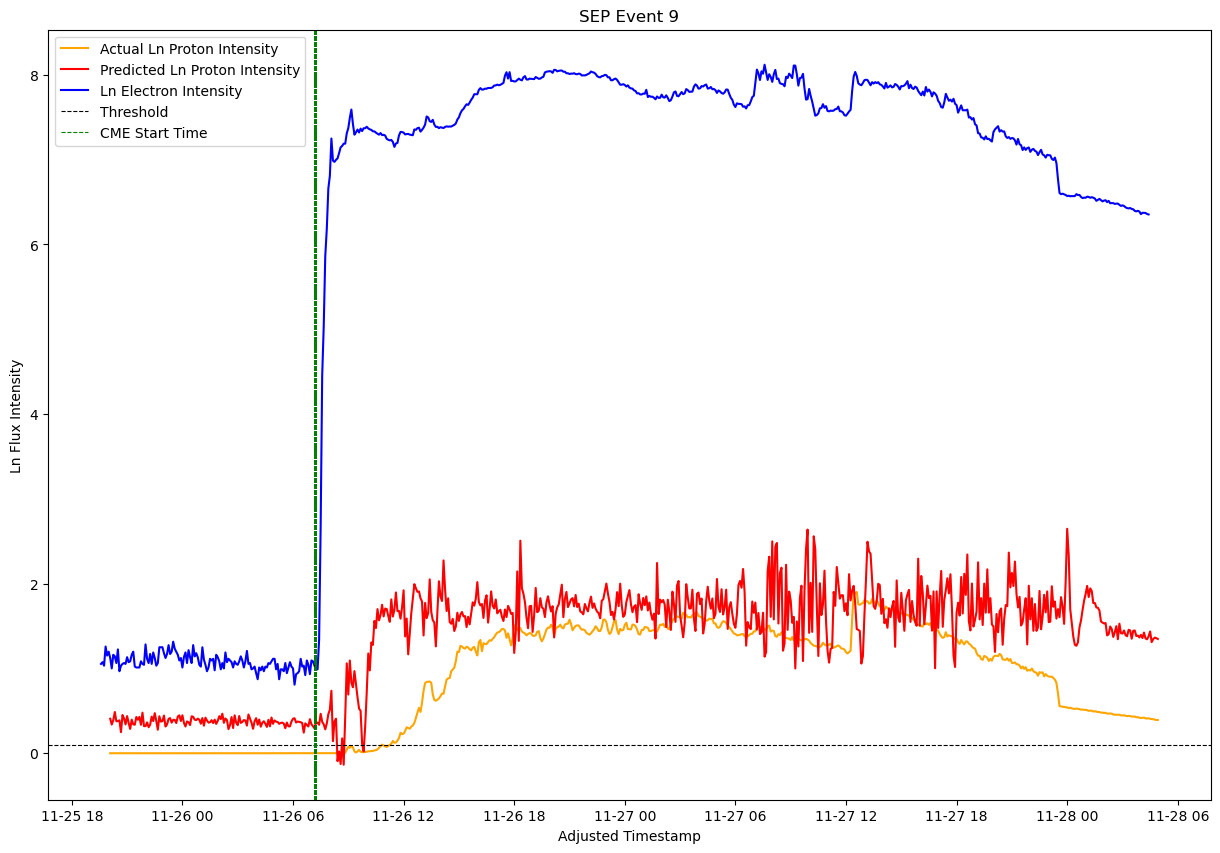

Saved plot to: C:\Users\the_3\OneDrive\Desktop\school\Fall 2023\keras-functional-api\notebooks\Y_SEP_Event_9_MAE_0.5209.png
Processed file: sep_event_9_filled_ie.csv with MAE: 0.5208957596787966


In [34]:
# Process SEP event files in the specified directory
test_directory = 'D:/College/Fall2023/electron_cme_data_split_12h/testing'
process_sep_events(test_directory, final_model_sep, using_y_model=False)

NameError: name 'show__plot' is not defined

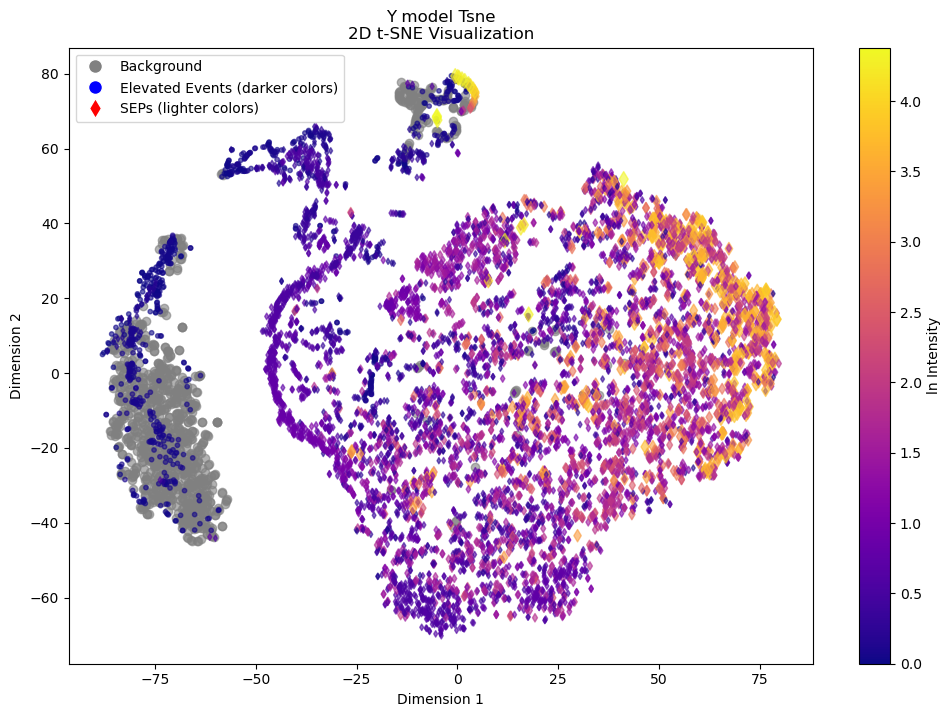

In [29]:
file_path = plot_tsne_extended(final_model_sep, 
                               X_test,
                               y_test, 
                               "Y model Tsne", 'testing_',
                               threshold=0.01, sep_threshold=0.1,
                               show_plot=True,
                               save_tag=None, seed=seed_value)
# print the path
print(f'file_path: {file_path}')

### With MLP only

# With CME data and Y net

In [ ]:
X_train, y_train = build_full_dataset('D:/College/Fall2023/electron_cme_data_split_12h/training')
X_subtrain, y_subtrain = build_full_dataset('D:/College/Fall2023/electron_cme_data_split_12h/subtraining')
X_test, y_test = build_full_dataset('D:/College/Fall2023/electron_cme_data_split_12h/testing')
X_val, y_val = build_full_dataset('D:/College/Fall2023/electron_cme_data_split_12h/validation')


In [ ]:
# Check for NaN values in each dataset
check_nan_in_dataset(X_train, "X_train")
check_nan_in_dataset(X_subtrain, "X_subtrain")
check_nan_in_dataset(X_test, "X_test")
check_nan_in_dataset(X_val, "X_val")
check_nan_in_dataset(y_train, "y_train")
check_nan_in_dataset(y_subtrain, "y_subtrain")
check_nan_in_dataset(y_test, "y_test")
check_nan_in_dataset(y_val, "y_val")

In [ ]:
# print all data shapes 
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_subtrain.shape: {X_subtrain.shape}')
print(f'y_subtrain.shape: {y_subtrain.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_val.shape: {y_val.shape}')

In [ ]:
# print a sample of the training data
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')

In [ ]:
# plot a training sample 
plot_sample_with_cme(X_train, sample_index=10000)
plot_sample_with_cme(X_train, sample_index=6)
plot_sample_with_cme(X_train, sample_index=60)
plot_sample_with_cme(X_train, sample_index=600)
plot_sample_with_cme(X_train, sample_index=6000)


In [ ]:
# create the model 
y_model_sep = create_y_shaped_model()
y_model_sep.summary()

In [ ]:
# Plot the model
plot_model(y_model_sep, show_shapes=True, show_layer_names=True)

### before training

In [ ]:
# Plot filters of the first convolutional layer
plot_conv1d_filters(y_model_sep, layer_index=1)

In [ ]:
# TODO: figure out a way to plot t-SNE

In [ ]:
# Set the early stopping patience and learning rate as variables
patience = 25
learning_rate = 3e-3

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_forecast_head_loss', patience=patience, verbose=1,
                               restore_best_weights=True)

# Compile the model with the specified learning rate
y_model_sep.compile(optimizer=Adam(learning_rate=learning_rate), loss={'forecast_head': 'mse'})

# Assuming X_combined is your original combined input data
cnn_input_subtrain, mlp_input_subtrain = prepare_inputs_for_y_model(X_subtrain)
cnn_input_val, mlp_input_val = prepare_inputs_for_y_model(X_val)

# Train the model with the callback
history = y_model_sep.fit(
    [cnn_input_subtrain, mlp_input_subtrain],
    {'forecast_head': y_subtrain},
    epochs=1000,
    batch_size=32,
    validation_data=([cnn_input_val, mlp_input_val], {'forecast_head': y_val}),
    callbacks=[early_stopping],
    verbose=1)

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Determine the optimal number of epochs from early stopping
optimal_epochs = early_stopping.stopped_epoch - patience + 1  # Adjust for the offset
y_final_model_sep = create_y_shaped_model()  # Recreate the model architecture
y_final_model_sep.compile(optimizer=Adam(learning_rate=learning_rate),
                        loss={'forecast_head': 'mse'})  # Compile the model just like before
# Train on the full dataset
cnn_input_train, mlp_input_train = prepare_inputs_for_y_model(X_train)
y_final_model_sep.fit(
    [cnn_input_train, mlp_input_train],
    {'forecast_head': y_train},
    epochs=optimal_epochs,
    batch_size=32, verbose=1)

### After training

In [ ]:
# Plot filters of the first convolutional layer
plot_conv1d_filters(y_final_model_sep, layer_index=1)

In [ ]:
# evaluate the model on test data
cnn_input_test, mlp_input_test = prepare_inputs_for_y_model(X_test)
error_mae = evaluate_model(y_final_model_sep, [cnn_input_test, mlp_input_test], y_test)
print(f'mae error: {error_mae}')

In [ ]:
# Process SEP event files in the specified directory
test_directory = 'D:/College/Fall2023/electron_cme_data_split_12h/testing'
process_sep_events(test_directory, y_final_model_sep)

In [ ]:
file_path = plot_tsne_extended(y_final_model_sep, 
                               [cnn_input_test, mlp_input_test],
                               y_test, 
                               "Y model Tsne", 'testing_',
                               threshold=0.01, sep_threshold=0.1,
                               show_plot=True,
                               save_tag=None, seed=seed_value)
# print the path
print(f'file_path: {file_path}')